In [1164]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE
from adjustText import adjust_text
from scipy.stats import mannwhitneyu, false_discovery_control, wilcoxon


import dimorph_processing as dp
import cell_comparison as cc
import sex_stats as ss
import sig_gene_analysis as sga

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [961]:
#load marker dict
folder = '/bigdata/isaac/gaba_files/'
with open (folder + 'GABA_mg_cl_dict_final_2024-09-02.json') as json_data:
    GABA_mg_cl_dict_final = json.load(json_data)
GABA_mg_cl_dict_final = {int(k):v for k,v in GABA_mg_cl_dict_final.items()}

In [2]:
gaba_folder = '/bigdata/isaac/gaba_files/'
#load in all filtered metadata with subclass labels
with open(gaba_folder + 'GABAmeta_data_df_plis_filtered_markers_2024-09-02.json') as json_data:
    gaba_metadata = json.load(json_data)
gaba_metadata = pd.DataFrame.from_dict(gaba_metadata, orient='columns')

In [3]:
len(np.unique(gaba_metadata.loc['cluster_label']))

50

In [384]:
output_folder = '/bigdata/isaac/gaba_files/sex_stats/volcano_plots/081124_run/'
all_genes_df = pd.read_csv(output_folder + 'all_genes_081124.csv',header=None)
all_genes_df.rename(columns = {0:'id',1:'test',2:'gene',3:'delta',4:'p_adj'}, 
            inplace = True)
all_genes_df.head()

,id,test,gene,delta,p_adj
0,2,ΔBN_m,0610007P14Rik,-0.081082,0.848014
1,2,ΔBN_m,0610009B22Rik,-0.274474,0.314746
2,2,ΔBN_m,0610009L18Rik,-0.064342,0.827115
3,2,ΔBN_m,0610009O20Rik,0.014070,0.992818
4,2,ΔBN_m,0610010F05Rik,-0.344001,0.196966


In [385]:
tmp_fix_t_p_adj = sga.format_genes(all_genes_df,gaba_metadata,GABA_mg_cl_dict_final, output_folder, 'all_genes_formatted_081124',write_to_file=False)

In [386]:
tmp_fix_t_p_adj

Sncg-Htr3a                                                    \
                   delta     p_adj     delta     p_adj     delta     p_adj   
id                    2         2         2         2         2         2    
test               ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B     Δmf_B   
gene                                                                         
0610007P14Rik  -0.089003  0.997251 -0.081082  0.848014 -0.042593  1.000000   
0610009B22Rik  -0.311795  0.433872 -0.274474  0.314746  0.094533  1.000000   
0610009L18Rik   0.047458  1.000000 -0.064342  0.827115 -0.093617  0.980656   
0610009O20Rik   0.126641  0.950423  0.014070  0.992818 -0.053795  1.000000   
0610010F05Rik   0.005795  1.000000 -0.344001  0.196966 -0.227545  0.821169   
...                  ...       ...       ...       ...       ...       ...   
Zyg11b         -0.228017  0.917640 -0.619184  0.059060 -0.369983  0.743593   
Zzef1          -0.198463  0.898447 -0.326248  0.185747 -0.212695  0.907614   
Zzz3            0.141243  0.934391 -0.147515  0.579810 -0.246324  0.765677   
l7Rn6          -0.322910  0.589918 -0.204682  0.493406  0.058121  1.000000   
mt-Nd6          0.017332  1.000000  0.096368  0.779667 -0.054857  1.000000   

                              Vip-Cbln2        ... Megf11-Gpc5            \
                  delta p_adj     delta p_adj  ...       delta     p_adj   
id                   2     2         3     3   ...          49        49   
test              Δmf_N Δmf_N     ΔBN_f ΔBN_f  ...       Δmf_N     Δmf_N   
gene                                           ...                         
0610007P14Rik -0.050513   1.0 -0.017356   1.0  ...   -0.163165  1.000000   
0610009B22Rik  0.057213   1.0 -0.207602   1.0  ...   -0.035206  1.000000   
0610009L18Rik  0.018183   1.0 -0.008062   1.0  ...   -0.091383  1.000000   
0610009O20Rik  0.058775   1.0  0.096425   1.0  ...   -0.003965  1.000000   
0610010F05Rik  0.122250   1.0  0.028714   1.0  ...   -0.229080  1.000000   
...                 ...   ...       ...   ...  ...         ...       ...   
Zyg11b         0.021183   1.0 -0.056526   1.0  ...   -0.353727  0.862964   
Zzef1         -0.084910   1.0 -0.013876   1.0  ...    0.141352  1.000000   
Zzz3           0.042435   1.0 -0.032544   1.0  ...   -0.056749  1.000000   
l7Rn6         -0.060107   1.0 -0.229050   1.0  ...    0.229988  1.000000   
mt-Nd6        -0.133893   1.0  0.052787   1.0  ...    0.334358  0.862964   

              BC048546-Dlx1                                                \
                      delta     p_adj     delta     p_adj     delta p_adj   
id                       50        50        50        50        50    50   
test                  ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B Δmf_B   
gene                                                                        
0610007P14Rik     -0.489908  0.945025 -0.457375  0.289762 -0.121821   1.0   
0610009B22Rik     -0.430928  0.700084  0.273235  0.571979  0.332198   1.0   
0610009L18Rik      0.065271  1.000000 -0.094286  0.891299 -0.052414   1.0   
0610009O20Rik      0.099754  1.000000  0.004286  1.000000 -0.166897   1.0   
0610010F05Rik     -0.033927  1.000000 -0.351596  0.524987 -0.061600   1.0   
...                     ...       ...       ...       ...       ...   ...   
Zyg11b            -0.110719  1.000000 -0.810484  0.043144 -0.340690   1.0   
Zzef1             -0.016010  1.000000 -0.315878  0.548164 -0.201479   1.0   
Zzz3              -0.246892  1.000000  0.131615  0.891299  0.265296   1.0   
l7Rn6              0.032788  1.000000 -0.159618  0.819944 -0.213297   1.0   
mt-Nd6            -0.228762  1.000000  0.053275  0.989987  0.210609   1.0   

                               
                  delta p_adj  
id                   50    50  
test              Δmf_N Δmf_N  
gene                           
0610007P14Rik -0.154355   1.0  
0610009B22Rik -0.371966   1.0  
0610009L18Rik  0.107143   1.0  
0610009O20Rik -0.071429   1.0  
0610010F05Rik  0.256069   1

In [387]:
'Malat1' in tmp_fix_t_p_adj.index

False

In [188]:
np.where(pd.isna(tmp_fix_t_p_adj)==True)

(array([], dtype=int64), array([], dtype=int64))

## get significant genes

### filter long form (all_genes_df_fix_t) stat results to get significant genes based on:

In [219]:
#define criteria for sig genes
#081124, drop log_fc criteria
log_fc = 1.5
alpha = 0.05

In [943]:
#gaba_sig_genes = all_genes_df_fix_t.iloc[np.where((all_genes_df_fix_t['delta']>log_fc) & (all_genes_df_fix_t['p_adj'] < alpha))]
gaba_sig_genes = all_genes_df.iloc[np.where(all_genes_df['p_adj'] < alpha)]

In [944]:
gaba_sig_genes

,id,test,gene,delta,p_adj
35,2,ΔBN_m,1700020I14Rik,-0.554542,0.045056
110,2,ΔBN_m,4930402H24Rik,-0.652269,0.009464
140,2,ΔBN_m,9530059O14Rik,-0.923545,0.004915
271,2,ΔBN_m,Actr3,-0.593266,0.027576
291,2,ΔBN_m,Adarb2,-0.703500,0.035380
...,...,...,...,...,...
1493676,50,ΔBN_m,Uhrf2,-0.784275,0.032128
1493836,50,ΔBN_m,Wdfy1,-0.745409,0.042103
1493926,50,ΔBN_m,Yaf2,-0.881011,0.043144
1493998,50,ΔBN_m,Zdbf2,-0.939425,0.042103


In [406]:
gaba_index = list(np.unique(gaba_sig_genes['gene']))

In [408]:
output_folder

'/bigdata/isaac/gaba_files/sex_stats/volcano_plots/081124_run/'

In [409]:
gaba_sig_genes.to_excel(output_folder + 'gaba_sig_genes_081124.xlsx')

In [ ]:
# use sig genes to fileter formated sig matrix

In [411]:
tmp_fix_t_p_adj

Sncg-Htr3a                                                    \
                   delta     p_adj     delta     p_adj     delta     p_adj   
id                    2         2         2         2         2         2    
test               ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B     Δmf_B   
gene                                                                         
0610007P14Rik  -0.089003  0.997251 -0.081082  0.848014 -0.042593  1.000000   
0610009B22Rik  -0.311795  0.433872 -0.274474  0.314746  0.094533  1.000000   
0610009L18Rik   0.047458  1.000000 -0.064342  0.827115 -0.093617  0.980656   
0610009O20Rik   0.126641  0.950423  0.014070  0.992818 -0.053795  1.000000   
0610010F05Rik   0.005795  1.000000 -0.344001  0.196966 -0.227545  0.821169   
...                  ...       ...       ...       ...       ...       ...   
Zyg11b         -0.228017  0.917640 -0.619184  0.059060 -0.369983  0.743593   
Zzef1          -0.198463  0.898447 -0.326248  0.185747 -0.212695  0.907614   
Zzz3            0.141243  0.934391 -0.147515  0.579810 -0.246324  0.765677   
l7Rn6          -0.322910  0.589918 -0.204682  0.493406  0.058121  1.000000   
mt-Nd6          0.017332  1.000000  0.096368  0.779667 -0.054857  1.000000   

                              Vip-Cbln2        ... Megf11-Gpc5            \
                  delta p_adj     delta p_adj  ...       delta     p_adj   
id                   2     2         3     3   ...          49        49   
test              Δmf_N Δmf_N     ΔBN_f ΔBN_f  ...       Δmf_N     Δmf_N   
gene                                           ...                         
0610007P14Rik -0.050513   1.0 -0.017356   1.0  ...   -0.163165  1.000000   
0610009B22Rik  0.057213   1.0 -0.207602   1.0  ...   -0.035206  1.000000   
0610009L18Rik  0.018183   1.0 -0.008062   1.0  ...   -0.091383  1.000000   
0610009O20Rik  0.058775   1.0  0.096425   1.0  ...   -0.003965  1.000000   
0610010F05Rik  0.122250   1.0  0.028714   1.0  ...   -0.229080  1.000000   
...                 ...   ...       ...   ...  ...         ...       ...   
Zyg11b         0.021183   1.0 -0.056526   1.0  ...   -0.353727  0.862964   
Zzef1         -0.084910   1.0 -0.013876   1.0  ...    0.141352  1.000000   
Zzz3           0.042435   1.0 -0.032544   1.0  ...   -0.056749  1.000000   
l7Rn6         -0.060107   1.0 -0.229050   1.0  ...    0.229988  1.000000   
mt-Nd6        -0.133893   1.0  0.052787   1.0  ...    0.334358  0.862964   

              BC048546-Dlx1                                                \
                      delta     p_adj     delta     p_adj     delta p_adj   
id                       50        50        50        50        50    50   
test                  ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B Δmf_B   
gene                                                                        
0610007P14Rik     -0.489908  0.945025 -0.457375  0.289762 -0.121821   1.0   
0610009B22Rik     -0.430928  0.700084  0.273235  0.571979  0.332198   1.0   
0610009L18Rik      0.065271  1.000000 -0.094286  0.891299 -0.052414   1.0   
0610009O20Rik      0.099754  1.000000  0.004286  1.000000 -0.166897   1.0   
0610010F05Rik     -0.033927  1.000000 -0.351596  0.524987 -0.061600   1.0   
...                     ...       ...       ...       ...       ...   ...   
Zyg11b            -0.110719  1.000000 -0.810484  0.043144 -0.340690   1.0   
Zzef1             -0.016010  1.000000 -0.315878  0.548164 -0.201479   1.0   
Zzz3              -0.246892  1.000000  0.131615  0.891299  0.265296   1.0   
l7Rn6              0.032788  1.000000 -0.159618  0.819944 -0.213297   1.0   
mt-Nd6            -0.228762  1.000000  0.053275  0.989987  0.210609   1.0   

                               
                  delta p_adj  
id                   50    50  
test              Δmf_N Δmf_N  
gene                           
0610007P14Rik -0.154355   1.0  
0610009B22Rik -0.371966   1.0  
0610009L18Rik  0.107143   1.0  
0610009O20Rik -0.071429   1.0  
0610010F05Rik  0.256069   1

## Use index of stat significant gaba genes to filter full matrix

In [412]:
gaba_sig_full = tmp_fix_t_p_adj.loc[gaba_index]

In [413]:
cols = gaba_sig_full.columns.get_level_values(1)

In [414]:
gaba_sig_full

Sncg-Htr3a                                                    \
                   delta     p_adj     delta     p_adj     delta     p_adj   
id                    2         2         2         2         2         2    
test               ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B     Δmf_B   
gene                                                                         
0610007P14Rik  -0.089003  0.997251 -0.081082  0.848014 -0.042593  1.000000   
0610009B22Rik  -0.311795  0.433872 -0.274474  0.314746  0.094533  1.000000   
0610010F05Rik   0.005795  1.000000 -0.344001  0.196966 -0.227545  0.821169   
0610011F06Rik  -0.103439  0.987193 -0.241604  0.303367  0.042336  1.000000   
1110001J03Rik  -0.217839  0.740804 -0.147887  0.510642 -0.110370  1.000000   
...                  ...       ...       ...       ...       ...       ...   
Zscan26        -0.079403  1.000000 -0.195402  0.507378 -0.116777  0.982650   
Zyg11b         -0.228017  0.917640 -0.619184  0.059060 -0.369983  0.743593   
Zzef1          -0.198463  0.898447 -0.326248  0.185747 -0.212695  0.907614   
l7Rn6          -0.322910  0.589918 -0.204682  0.493406  0.058121  1.000000   
mt-Nd6          0.017332  1.000000  0.096368  0.779667 -0.054857  1.000000   

                              Vip-Cbln2        ... Megf11-Gpc5            \
                  delta p_adj     delta p_adj  ...       delta     p_adj   
id                   2     2         3     3   ...          49        49   
test              Δmf_N Δmf_N     ΔBN_f ΔBN_f  ...       Δmf_N     Δmf_N   
gene                                           ...                         
0610007P14Rik -0.050513   1.0 -0.017356   1.0  ...   -0.163165  1.000000   
0610009B22Rik  0.057213   1.0 -0.207602   1.0  ...   -0.035206  1.000000   
0610010F05Rik  0.122250   1.0  0.028714   1.0  ...   -0.229080  1.000000   
0610011F06Rik  0.180500   1.0 -0.184100   1.0  ...    0.125534  1.000000   
1110001J03Rik -0.180321   1.0 -0.127906   1.0  ...    0.022755  1.000000   
...                 ...   ...       ...   ...  ...         ...       ...   
Zscan26       -0.000777   1.0 -0.066386   1.0  ...   -0.107185  1.000000   
Zyg11b         0.021183   1.0 -0.056526   1.0  ...   -0.353727  0.862964   
Zzef1         -0.084910   1.0 -0.013876   1.0  ...    0.141352  1.000000   
l7Rn6         -0.060107   1.0 -0.229050   1.0  ...    0.229988  1.000000   
mt-Nd6        -0.133893   1.0  0.052787   1.0  ...    0.334358  0.862964   

              BC048546-Dlx1                                                \
                      delta     p_adj     delta     p_adj     delta p_adj   
id                       50        50        50        50        50    50   
test                  ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B Δmf_B   
gene                                                                        
0610007P14Rik     -0.489908  0.945025 -0.457375  0.289762 -0.121821   1.0   
0610009B22Rik     -0.430928  0.700084  0.273235  0.571979  0.332198   1.0   
0610010F05Rik     -0.033927  1.000000 -0.351596  0.524987 -0.061600   1.0   
0610011F06Rik     -0.437927  0.945025 -0.331848  0.566980 -0.274698   1.0   
1110001J03Rik     -0.163701  1.000000 -0.474103  0.228658 -0.423614   1.0   
...                     ...       ...       ...       ...       ...   ...   
Zscan26           -0.264045  1.000000 -0.174168  0.837669 -0.125048   1.0   
Zyg11b            -0.110719  1.000000 -0.810484  0.043144 -0.340690   1.0   
Zzef1             -0.016010  1.000000 -0.315878  0.548164 -0.201479   1.0   
l7Rn6              0.032788  1.000000 -0.159618  0.819944 -0.213297   1.0   
mt-Nd6            -0.228762  1.000000  0.053275  0.989987  0.210609   1.0   

                               
                  delta p_adj  
id                   50    50  
test              Δmf_N Δmf_N  
gene                           
0610007P14Rik -0.154355   1.0  
0610009B22Rik -0.371966   1.0  
0610010F05Rik  0.256069   1.0  
0610011F06Rik -0.380778   1.0  
1110001J03Rik -0.113212   1

In [585]:
gaba_sig_deltas = gaba_sig_full.iloc[:,::2]

In [586]:
gaba_sig_deltas

Sncg-Htr3a                               Vip-Cbln2            \
                   delta                                   delta             
id                    2                                       3              
test               ΔBN_f     ΔBN_m     Δmf_B     Δmf_N     ΔBN_f     ΔBN_m   
gene                                                                         
0610007P14Rik  -0.089003 -0.081082 -0.042593 -0.050513 -0.017356 -0.219023   
0610009B22Rik  -0.311795 -0.274474  0.094533  0.057213 -0.207602 -0.177859   
0610010F05Rik   0.005795 -0.344001 -0.227545  0.122250  0.028714 -0.022957   
0610011F06Rik  -0.103439 -0.241604  0.042336  0.180500 -0.184100 -0.018922   
1110001J03Rik  -0.217839 -0.147887 -0.110370 -0.180321 -0.127906 -0.414141   
...                  ...       ...       ...       ...       ...       ...   
Zscan26        -0.079403 -0.195402 -0.116777 -0.000777 -0.066386 -0.132393   
Zyg11b         -0.228017 -0.619184 -0.369983  0.021183 -0.056526  0.087012   
Zzef1          -0.198463 -0.326248 -0.212695 -0.084910 -0.013876 -0.072957   
l7Rn6          -0.322910 -0.204682  0.058121 -0.060107 -0.229050 -0.063417   
mt-Nd6          0.017332  0.096368 -0.054857 -0.133893  0.052787  0.191485   

                                  Cpne4-Pde3a            ... Ptn-Ndst4  \
                                        delta            ...     delta   
id                                         4             ...        48   
test              Δmf_B     Δmf_N       ΔBN_f     ΔBN_m  ...     Δmf_B   
gene                                                     ...             
0610007P14Rik -0.318958 -0.117292   -0.735840  0.250000  ...  0.100178   
0610009B22Rik -0.003968 -0.033711   -0.166667  0.135213  ... -0.288859   
0610010F05Rik -0.058065 -0.006394   -0.083333 -0.406454  ... -0.125906   
0610011F06Rik  0.080675 -0.084503   -0.166667 -0.198120  ...  0.031683   
1110001J03Rik -0.237609  0.048627   -0.479574  0.083333  ...  0.160145   
...                 ...       ...         ...       ...  ...       ...   
Zscan26       -0.168242 -0.102235    0.083333 -0.360840  ...  0.198811   
Zyg11b         0.016509 -0.127030   -0.161759 -0.519815  ...  0.057806   
Zzef1         -0.104225 -0.045143    0.083333 -0.896241  ...  0.553534   
l7Rn6          0.120208 -0.045425   -0.166667 -0.058960  ... -0.153178   
mt-Nd6         0.130129 -0.008569    0.166667  0.163534  ...  0.246822   

                        Megf11-Gpc5                                \
                              delta                                 
id                               49                                 
test              Δmf_N       ΔBN_f     ΔBN_m     Δmf_B     Δmf_N   
gene                                                                
0610007P14Rik -0.301955   -0.346411 -0.170196  0.013051 -0.163165   
0610009B22Rik -0.040248   -0.193542 -0.062288  0.096048 -0.035206   
0610010F05Rik -0.060806   -0.521075 -0.220947  0.071048 -0.229080   
0610011F06Rik -0.403011   -0.009556 -0.104099  0.030991  0.125534   
1110001J03Rik -0.119076   -0.271105 -0.561373 -0.267514  0.022755   
...                 ...         ...       ...       ...       ...   
Zscan26       -0.084619   -0.214095 -0.313594 -0.206684 -0.107185   
Zyg11b        -0.319774   -0.718774 -0.521094 -0.156047 -0.353727   
Zzef1          0.067405   -0.310354 -0.643236 -0.191529  0.141352   
l7Rn6         -0.074537   -0.258632 -0.436634  0.051986  0.229988   
mt-Nd6        -0.030956    0.005672 -0.255984  0.072702  0.334358   

              BC048546-Dlx1                                
                      delta                                
id                       50                                
test                  ΔBN_f     ΔBN_m     Δmf_B     Δmf_N  
gene                                                       
0610007P14Rik     -0.489908 -0.457375 -0.121821 -0.154355  
0610009B22Rik     -0.430928  0.273235  0.332198 -0.371966  
0610010F05Rik     -0.033927 -0.351596 -0.061600  0.2560

## Approach #1 Get Abs max FC value for each gene, sort index from high to low (largest to smallest FC difference)

In [587]:
#rank by strongest
#take abs value of gene avg, sort high to low, get first 20
#strongest_genes = np.abs(np.mean(gaba_sig_deltas,axis=1)).sort_values(ascending=False)[:20].index
#alternatively, use abs max delta expr of each gene
strongest_genes = np.max(np.abs(gaba_sig_deltas),axis=1).sort_values(ascending=False)[:20].index

In [588]:
#update gaba_sig_deltas using these genes
gaba_sig_deltas_strongest = gaba_sig_deltas.loc[strongest_genes]

In [417]:
gaba_sig_deltas_strongest.iloc[:,::4].head()

,Sncg-Htr3a,Vip-Cbln2,Cpne4-Pde3a,Reln-Ndnf,Dab1-Nfib,Kit-Pdlim5,Hcrtr2-Id2,Pthlh-Pvalb,Rbp4-Kitl,Moxd1-Vwc2,...,Col11a1-Pde11a,Pax6-Npnt,Calca,Dsc3-Mfge8,Nrn1-Slc17a7,Pou3f2-Zfhx3,Cyp26b1-Dach1,Ptn-Ndst4,Megf11-Gpc5,BC048546-Dlx1
,delta,delta,delta,delta,delta,delta,delta,delta,delta,delta,...,delta,delta,delta,delta,delta,delta,delta,delta,delta,delta
id,2,3,4,5,6,7,8,9,10,11,...,41,42,43,44,45,46,47,48,49,50
test,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,...,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f,ΔBN_f
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,-0.089003,-0.017356,-0.735840,-0.279020,-0.354327,-0.310798,-0.153079,-0.323030,-0.190027,-0.222515,...,-0.082476,-0.477448,-0.129122,-0.168835,-0.684576,-0.356548,0.086216,-0.264388,-0.346411,-0.489908
0610009B22Rik,-0.311795,-0.207602,-0.166667,-0.017573,-0.371144,-0.183235,-0.441546,0.052386,-0.261845,-0.078977,...,-0.280556,-0.152148,-0.269197,-0.077158,-0.283022,-0.229063,-0.192572,-0.189134,-0.193542,-0.430928
0610010F05Rik,0.005795,0.028714,-0.083333,-0.466792,-0.180942,0.022051,0.020610,-0.207565,-0.163317,-0.172153,...,-0.057686,-0.175815,-0.171257,-0.231715,-0.461468,-0.076399,0.102338,-0.243397,-0.521075,-0.033927
0610011F06Rik,-0.103439,-0.184100,-0.166667,-0.301794,-0.164878,-0.167531,-0.301665,-0.137165,-0.286839,-0.258311,...,-0.226168,-0.083179,-0.392093,-0.134597,-0.598345,-0.427120,-0.027325,-0.176197,-0.009556,-0.437927
1110001J03Rik,-0.217839,-0.127906,-0.479574,-0.360660,-0.096394,-0.196058,-0.230112,-0.473482,-0.627387,-0.422055,...,-0.289213,-0.395339,-0.254098,-0.227806,-0.390634,-0.221810,-0.121905,-0.236581,-0.271105,-0.163701


In [418]:
gaba_sig_full

Sncg-Htr3a                                                    \
                   delta     p_adj     delta     p_adj     delta     p_adj   
id                    2         2         2         2         2         2    
test               ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B     Δmf_B   
gene                                                                         
0610007P14Rik  -0.089003  0.997251 -0.081082  0.848014 -0.042593  1.000000   
0610009B22Rik  -0.311795  0.433872 -0.274474  0.314746  0.094533  1.000000   
0610010F05Rik   0.005795  1.000000 -0.344001  0.196966 -0.227545  0.821169   
0610011F06Rik  -0.103439  0.987193 -0.241604  0.303367  0.042336  1.000000   
1110001J03Rik  -0.217839  0.740804 -0.147887  0.510642 -0.110370  1.000000   
...                  ...       ...       ...       ...       ...       ...   
Zscan26        -0.079403  1.000000 -0.195402  0.507378 -0.116777  0.982650   
Zyg11b         -0.228017  0.917640 -0.619184  0.059060 -0.369983  0.743593   
Zzef1          -0.198463  0.898447 -0.326248  0.185747 -0.212695  0.907614   
l7Rn6          -0.322910  0.589918 -0.204682  0.493406  0.058121  1.000000   
mt-Nd6          0.017332  1.000000  0.096368  0.779667 -0.054857  1.000000   

                              Vip-Cbln2        ... Megf11-Gpc5            \
                  delta p_adj     delta p_adj  ...       delta     p_adj   
id                   2     2         3     3   ...          49        49   
test              Δmf_N Δmf_N     ΔBN_f ΔBN_f  ...       Δmf_N     Δmf_N   
gene                                           ...                         
0610007P14Rik -0.050513   1.0 -0.017356   1.0  ...   -0.163165  1.000000   
0610009B22Rik  0.057213   1.0 -0.207602   1.0  ...   -0.035206  1.000000   
0610010F05Rik  0.122250   1.0  0.028714   1.0  ...   -0.229080  1.000000   
0610011F06Rik  0.180500   1.0 -0.184100   1.0  ...    0.125534  1.000000   
1110001J03Rik -0.180321   1.0 -0.127906   1.0  ...    0.022755  1.000000   
...                 ...   ...       ...   ...  ...         ...       ...   
Zscan26       -0.000777   1.0 -0.066386   1.0  ...   -0.107185  1.000000   
Zyg11b         0.021183   1.0 -0.056526   1.0  ...   -0.353727  0.862964   
Zzef1         -0.084910   1.0 -0.013876   1.0  ...    0.141352  1.000000   
l7Rn6         -0.060107   1.0 -0.229050   1.0  ...    0.229988  1.000000   
mt-Nd6        -0.133893   1.0  0.052787   1.0  ...    0.334358  0.862964   

              BC048546-Dlx1                                                \
                      delta     p_adj     delta     p_adj     delta p_adj   
id                       50        50        50        50        50    50   
test                  ΔBN_f     ΔBN_f     ΔBN_m     ΔBN_m     Δmf_B Δmf_B   
gene                                                                        
0610007P14Rik     -0.489908  0.945025 -0.457375  0.289762 -0.121821   1.0   
0610009B22Rik     -0.430928  0.700084  0.273235  0.571979  0.332198   1.0   
0610010F05Rik     -0.033927  1.000000 -0.351596  0.524987 -0.061600   1.0   
0610011F06Rik     -0.437927  0.945025 -0.331848  0.566980 -0.274698   1.0   
1110001J03Rik     -0.163701  1.000000 -0.474103  0.228658 -0.423614   1.0   
...                     ...       ...       ...       ...       ...   ...   
Zscan26           -0.264045  1.000000 -0.174168  0.837669 -0.125048   1.0   
Zyg11b            -0.110719  1.000000 -0.810484  0.043144 -0.340690   1.0   
Zzef1             -0.016010  1.000000 -0.315878  0.548164 -0.201479   1.0   
l7Rn6              0.032788  1.000000 -0.159618  0.819944 -0.213297   1.0   
mt-Nd6            -0.228762  1.000000  0.053275  0.989987  0.210609   1.0   

                               
                  delta p_adj  
id                   50    50  
test              Δmf_N Δmf_N  
gene                           
0610007P14Rik -0.154355   1.0  
0610009B22Rik -0.371966   1.0  
0610010F05Rik  0.256069   1.0  
0610011F06Rik -0.380778   1.0  
1110001J03Rik -0.113212   1

In [419]:
gaba_sig_p_adj = gaba_sig_full.iloc[:,1::2]

In [421]:
gaba_sig_p_adj

Sncg-Htr3a                           Vip-Cbln2                  \
                   p_adj                               p_adj                   
id                    2                                   3                    
test               ΔBN_f     ΔBN_m     Δmf_B Δmf_N     ΔBN_f     ΔBN_m Δmf_B   
gene                                                                           
0610007P14Rik   0.997251  0.848014  1.000000   1.0       1.0  1.000000   1.0   
0610009B22Rik   0.433872  0.314746  1.000000   1.0       1.0  1.000000   1.0   
0610010F05Rik   1.000000  0.196966  0.821169   1.0       1.0  1.000000   1.0   
0610011F06Rik   0.987193  0.303367  1.000000   1.0       1.0  1.000000   1.0   
1110001J03Rik   0.740804  0.510642  1.000000   1.0       1.0  0.748092   1.0   
...                  ...       ...       ...   ...       ...       ...   ...   
Zscan26         1.000000  0.507378  0.982650   1.0       1.0  1.000000   1.0   
Zyg11b          0.917640  0.059060  0.743593   1.0       1.0  1.000000   1.0   
Zzef1           0.898447  0.185747  0.907614   1.0       1.0  1.000000   1.0   
l7Rn6           0.589918  0.493406  1.000000   1.0       1.0  1.000000   1.0   
mt-Nd6          1.000000  0.779667  1.000000   1.0       1.0  1.000000   1.0   

                    Cpne4-Pde3a        ... Ptn-Ndst4       Megf11-Gpc5  \
                          p_adj        ...     p_adj             p_adj   
id                           4         ...        48                49   
test          Δmf_N       ΔBN_f ΔBN_m  ...     Δmf_B Δmf_N       ΔBN_f   
gene                                   ...                               
0610007P14Rik   1.0         1.0   1.0  ...       1.0   1.0    0.037098   
0610009B22Rik   1.0         1.0   1.0  ...       1.0   1.0    0.229757   
0610010F05Rik   1.0         1.0   1.0  ...       1.0   1.0    0.003405   
0610011F06Rik   1.0         1.0   1.0  ...       1.0   1.0    0.920495   
1110001J03Rik   1.0         1.0   1.0  ...       1.0   1.0    0.125367   
...             ...         ...   ...  ...       ...   ...         ...   
Zscan26         1.0         1.0   1.0  ...       1.0   1.0    0.279020   
Zyg11b          1.0         1.0   1.0  ...       1.0   1.0    0.000166   
Zzef1           1.0         1.0   1.0  ...       1.0   1.0    0.121150   
l7Rn6           1.0         1.0   1.0  ...       1.0   1.0    0.139929   
mt-Nd6          1.0         1.0   1.0  ...       1.0   1.0    0.956915   

                                        BC048546-Dlx1                        
                                                p_adj                        
id                                                 50                        
test              ΔBN_m Δmf_B     Δmf_N         ΔBN_f     ΔBN_m Δmf_B Δmf_N  
gene                                                                         
0610007P14Rik  0.873183   1.0  1.000000      0.945025  0.289762   1.0   1.0  
0610009B22Rik  0.980275   1.0  1.000000      0.700084  0.571979   1.0   1.0  
0610010F05Rik  0.797098   1.0  1.000000      1.000000  0.524987   1.0   1.0  
0610011F06Rik  0.882264   1.0  1.000000      0.945025  0.566980   1.0   1.0  
1110001J03Rik  0.346130   1.0  1.000000      1.000000  0.228658   1.0   1.0  
...                 ...   ...       ...           ...       ...   ...   ...  
Zscan26        0.663440   1.0  1.000000      1.000000  0.837669   1.0   1.0  
Zyg11b         0.438580   1.0  0.862964      1.000000  0.043144   1.0   1.0  
Zzef1          0.251469   1.0  1.000000      1.000000  0.548164   1.0   1.0  
l7Rn6          0.473510   1.0  1.000000      1.000000  0.819944   1.0   1.0  
mt-Nd6         0.797530   1.0  0.862964      1.000000  0.989987   1.0   1.0  

[3629 rows x 196 columns]

In [279]:
ind_2_title_dict = {1:'ΔBN_f',2:'ΔBN_m',3:'Δmf_B',4:'Δmf_N'}

### Heatmap of strongest sig Genes

In [581]:
output_folder = '/bigdata/isaac/gaba_files/sex_stats/volcano_plots/081124_run/sig_gene_heatmaps/'

In [583]:
def plot_sig_gene_heatmap(delta_df,ind_2_title_dict,output_folder = None, outfile_name = None, savefig = False):
    fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=False)  # Adjust height to fit all heatmaps
    vmin = delta_df.min().min()
    vmax = delta_df.max().max()
    
    # Plot each heatmap on its respective subplot
    for i, ax in enumerate(axes):
        # Set the title for each subplot
        ax.set_title(ind_2_title_dict[i+1])
        
        # Plot the heatmap, selecting every 4th column starting at i for each subplot
        sns.heatmap(delta_df.iloc[:, i::4], ax=ax, vmin=vmin, vmax=vmax, cbar=True)
        ax.set_xticklabels(delta_df.iloc[:, ::4].columns.get_level_values(2)) #use (2) for id, (0) for cell type
        ax.set_xlabel('')
    if savefig:
        plt.savefig(output_folder+outfile_name+'.png')
    # Show the entire figure with all 4 heatmaps
    plt.tight_layout()
    plt.show()

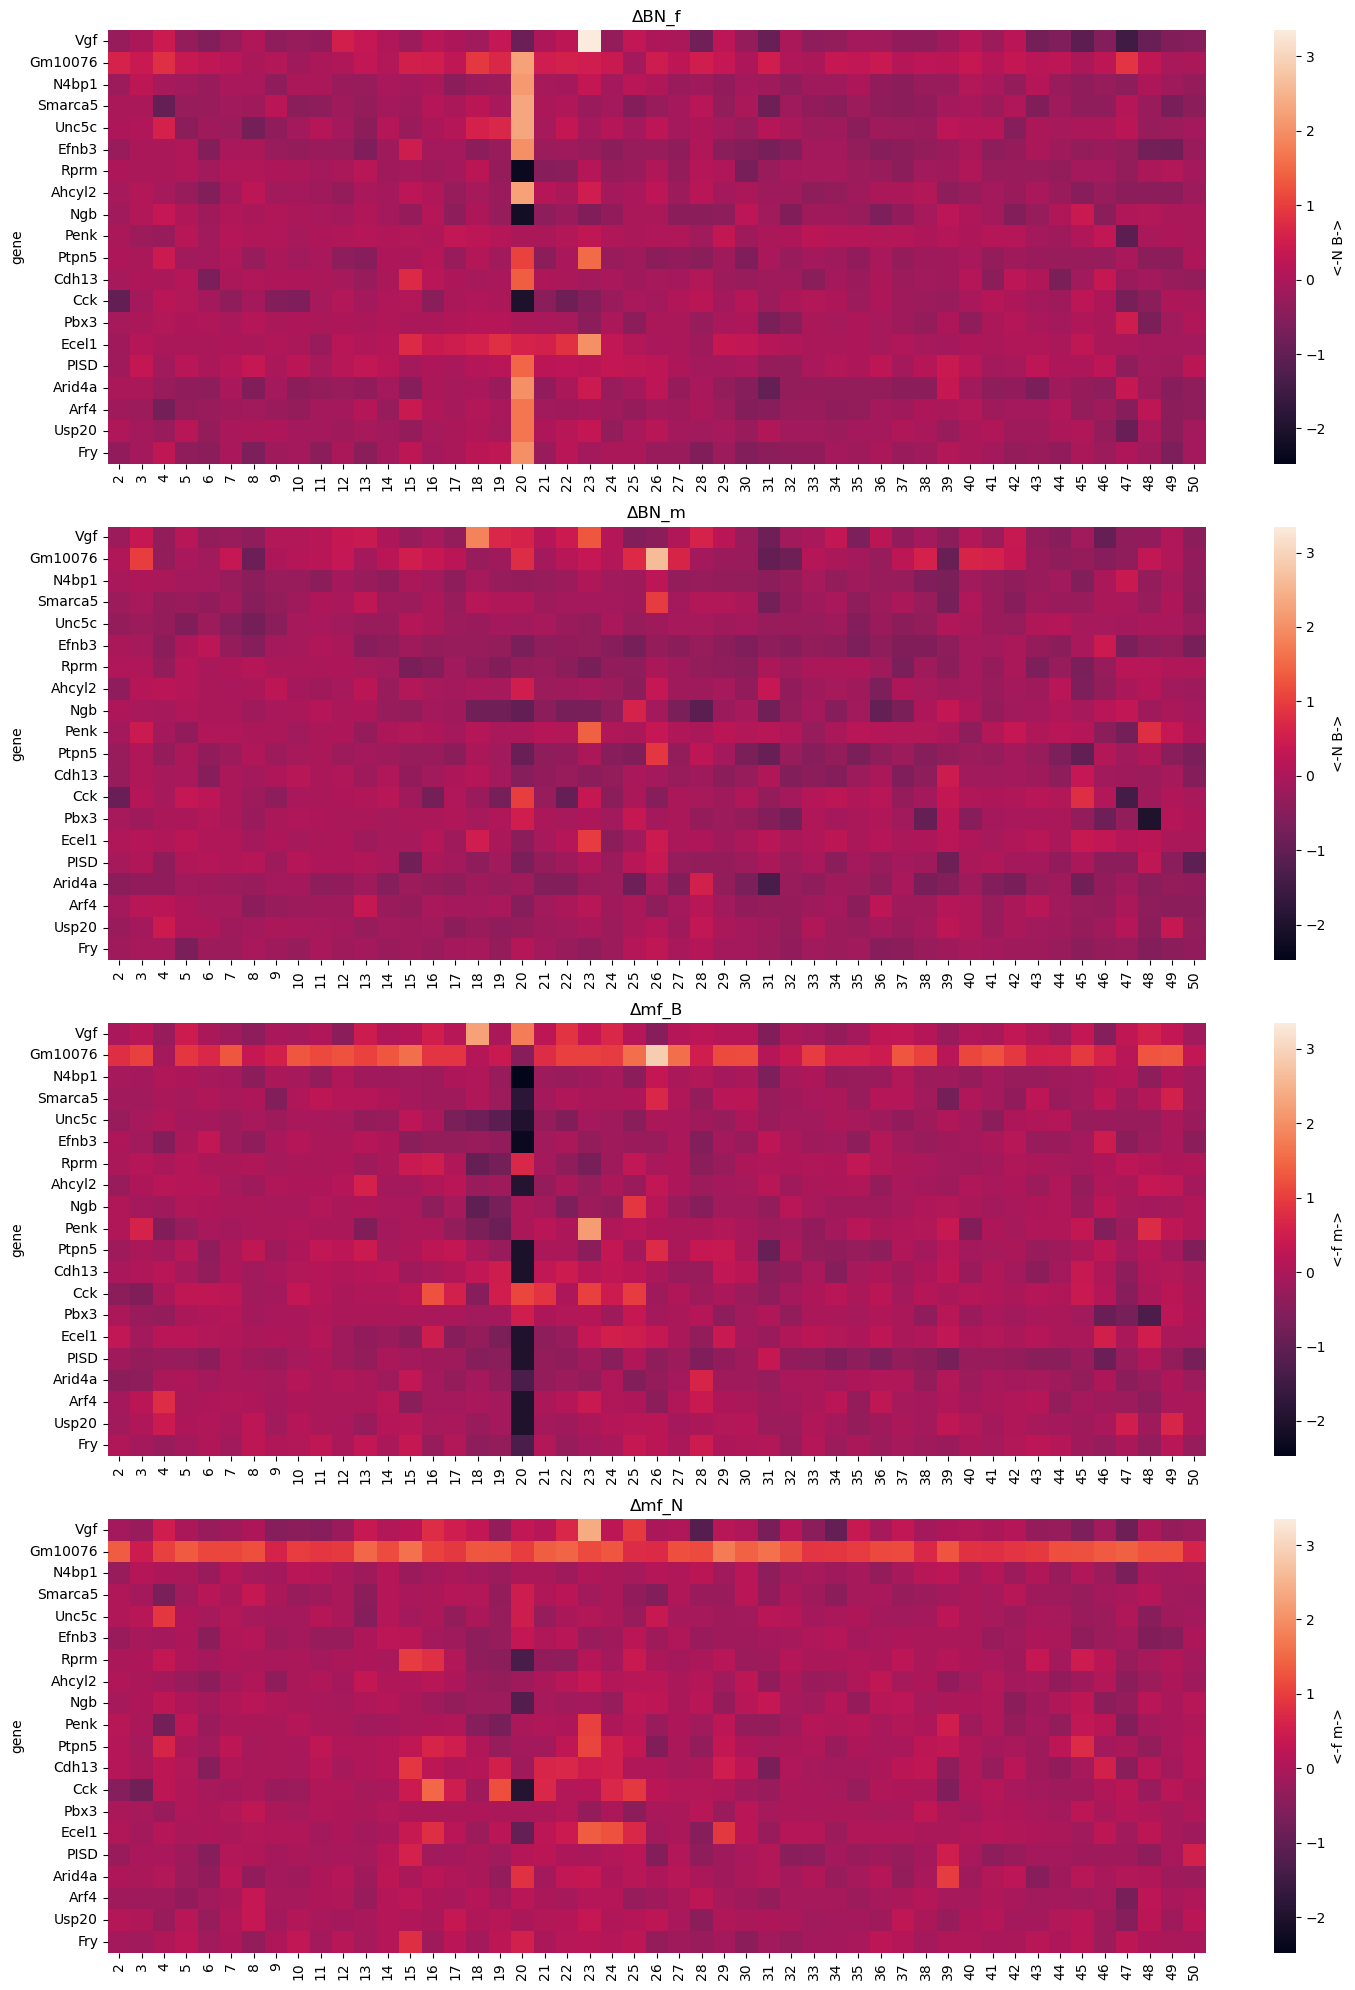

In [1194]:
sga.plot_sig_gene_heatmap(gaba_sig_deltas_strongest,ind_2_title_dict,output_folder, outfile_name= 'gaba_sig_deltas_max_abs_ranking_top20',savefig = True)

### Quick check of sDEGs from chen et al (see fig 6, "Sexually Dimorphic Control of Parenting Behavior")

In [318]:
output_folder

'/bigdata/isaac/gaba_files/sex_stats/volcano_plots/311024_fix_t_run/'

In [377]:
chen_list = ['Brs3','Socs2','FiBin','Greb1','Fam84a','Gpr176']

In [378]:
intersected_chen_list = []
for g in chen_list:
    if g in tmp_fix_t_p_adj.index:
        intersected_chen_list.append(g)

In [379]:
chen_deltas = tmp_fix_t_p_adj.loc[intersected_chen_list].iloc[:,::2]

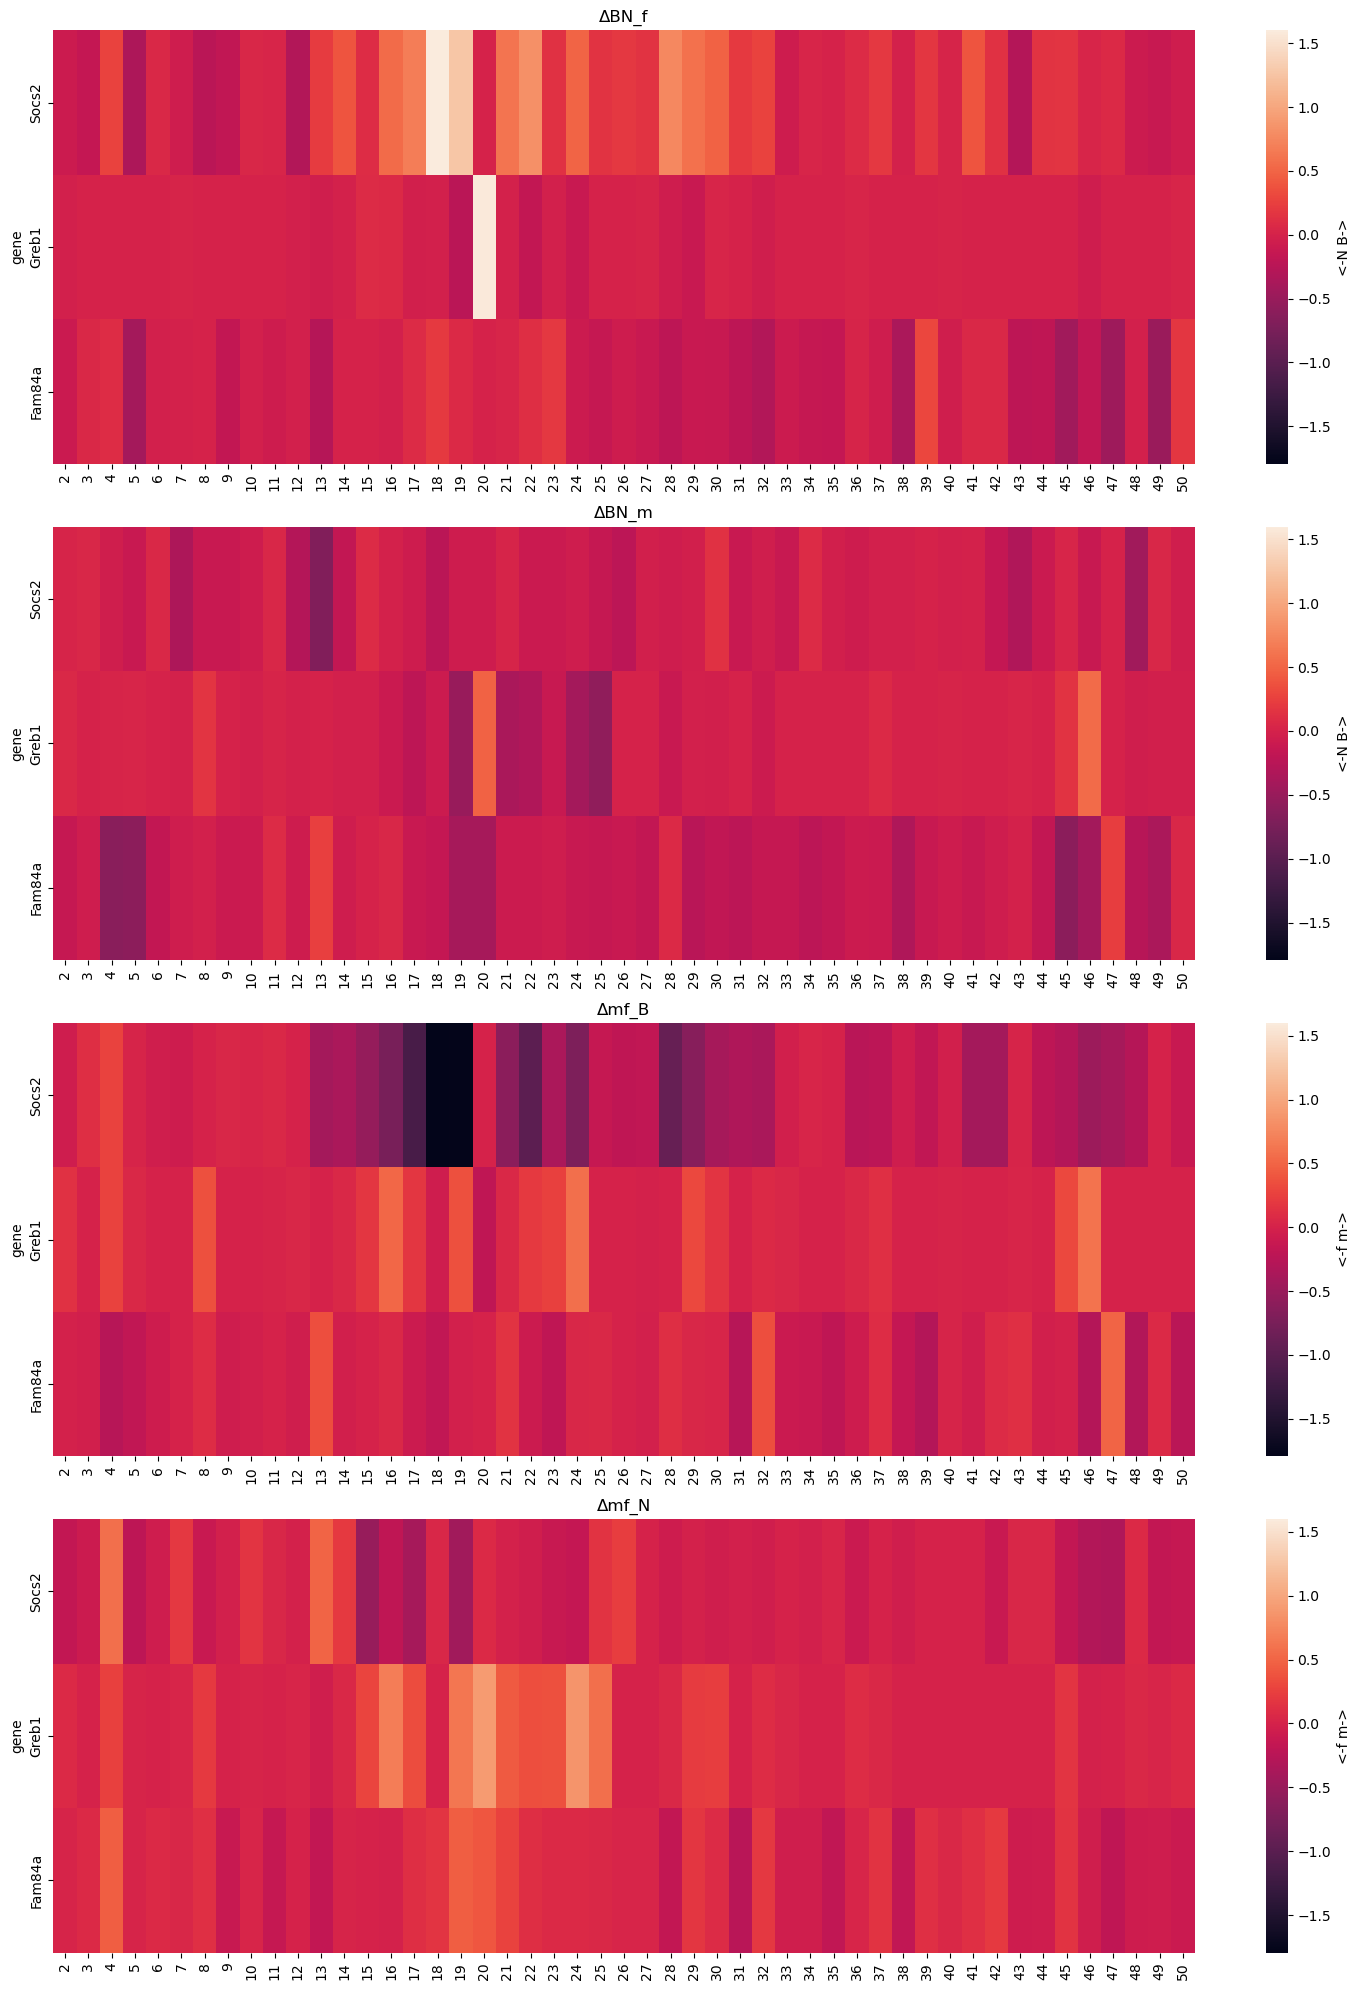

In [1195]:
sga.plot_sig_gene_heatmap(chen_deltas,ind_2_title_dict,output_folder, outfile_name= 'chen_genes', savefig = True)

### Other genes

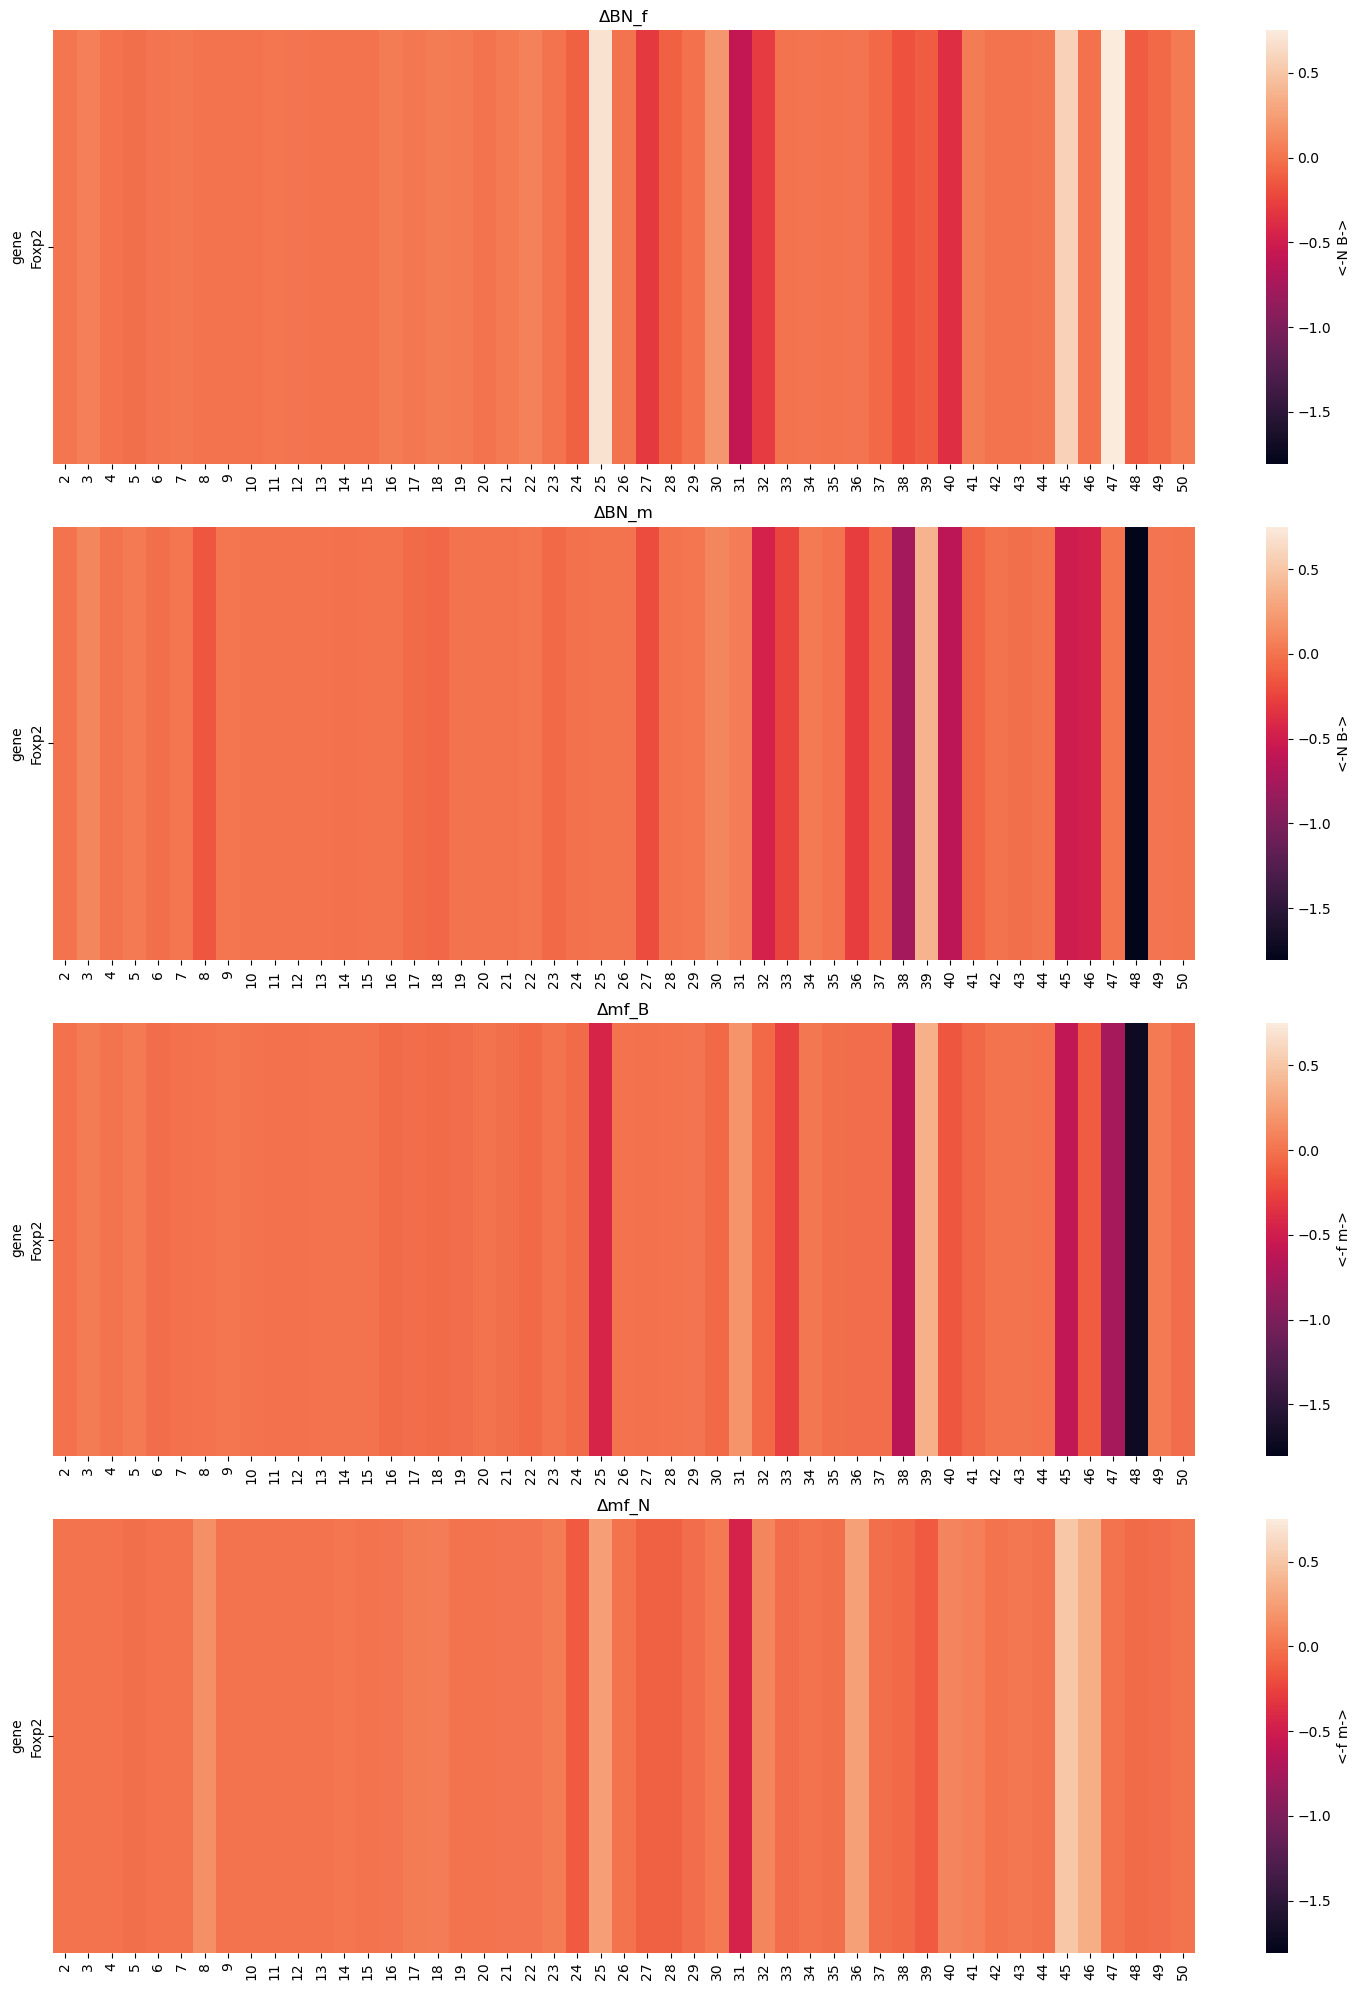

In [1202]:
gene_list = ['Foxp2','Cntnap2','Pax2','Rln3']
intersected_gene_list = []
for g in gene_list:
    if g in tmp_fix_t_p_adj.index:
        intersected_gene_list.append(g)

gene_deltas = tmp_fix_t_p_adj.loc[intersected_gene_list].iloc[:,::2]
sga.plot_sig_gene_heatmap(gene_deltas,ind_2_title_dict,output_folder, outfile_name= 'foxp2', savefig = True)



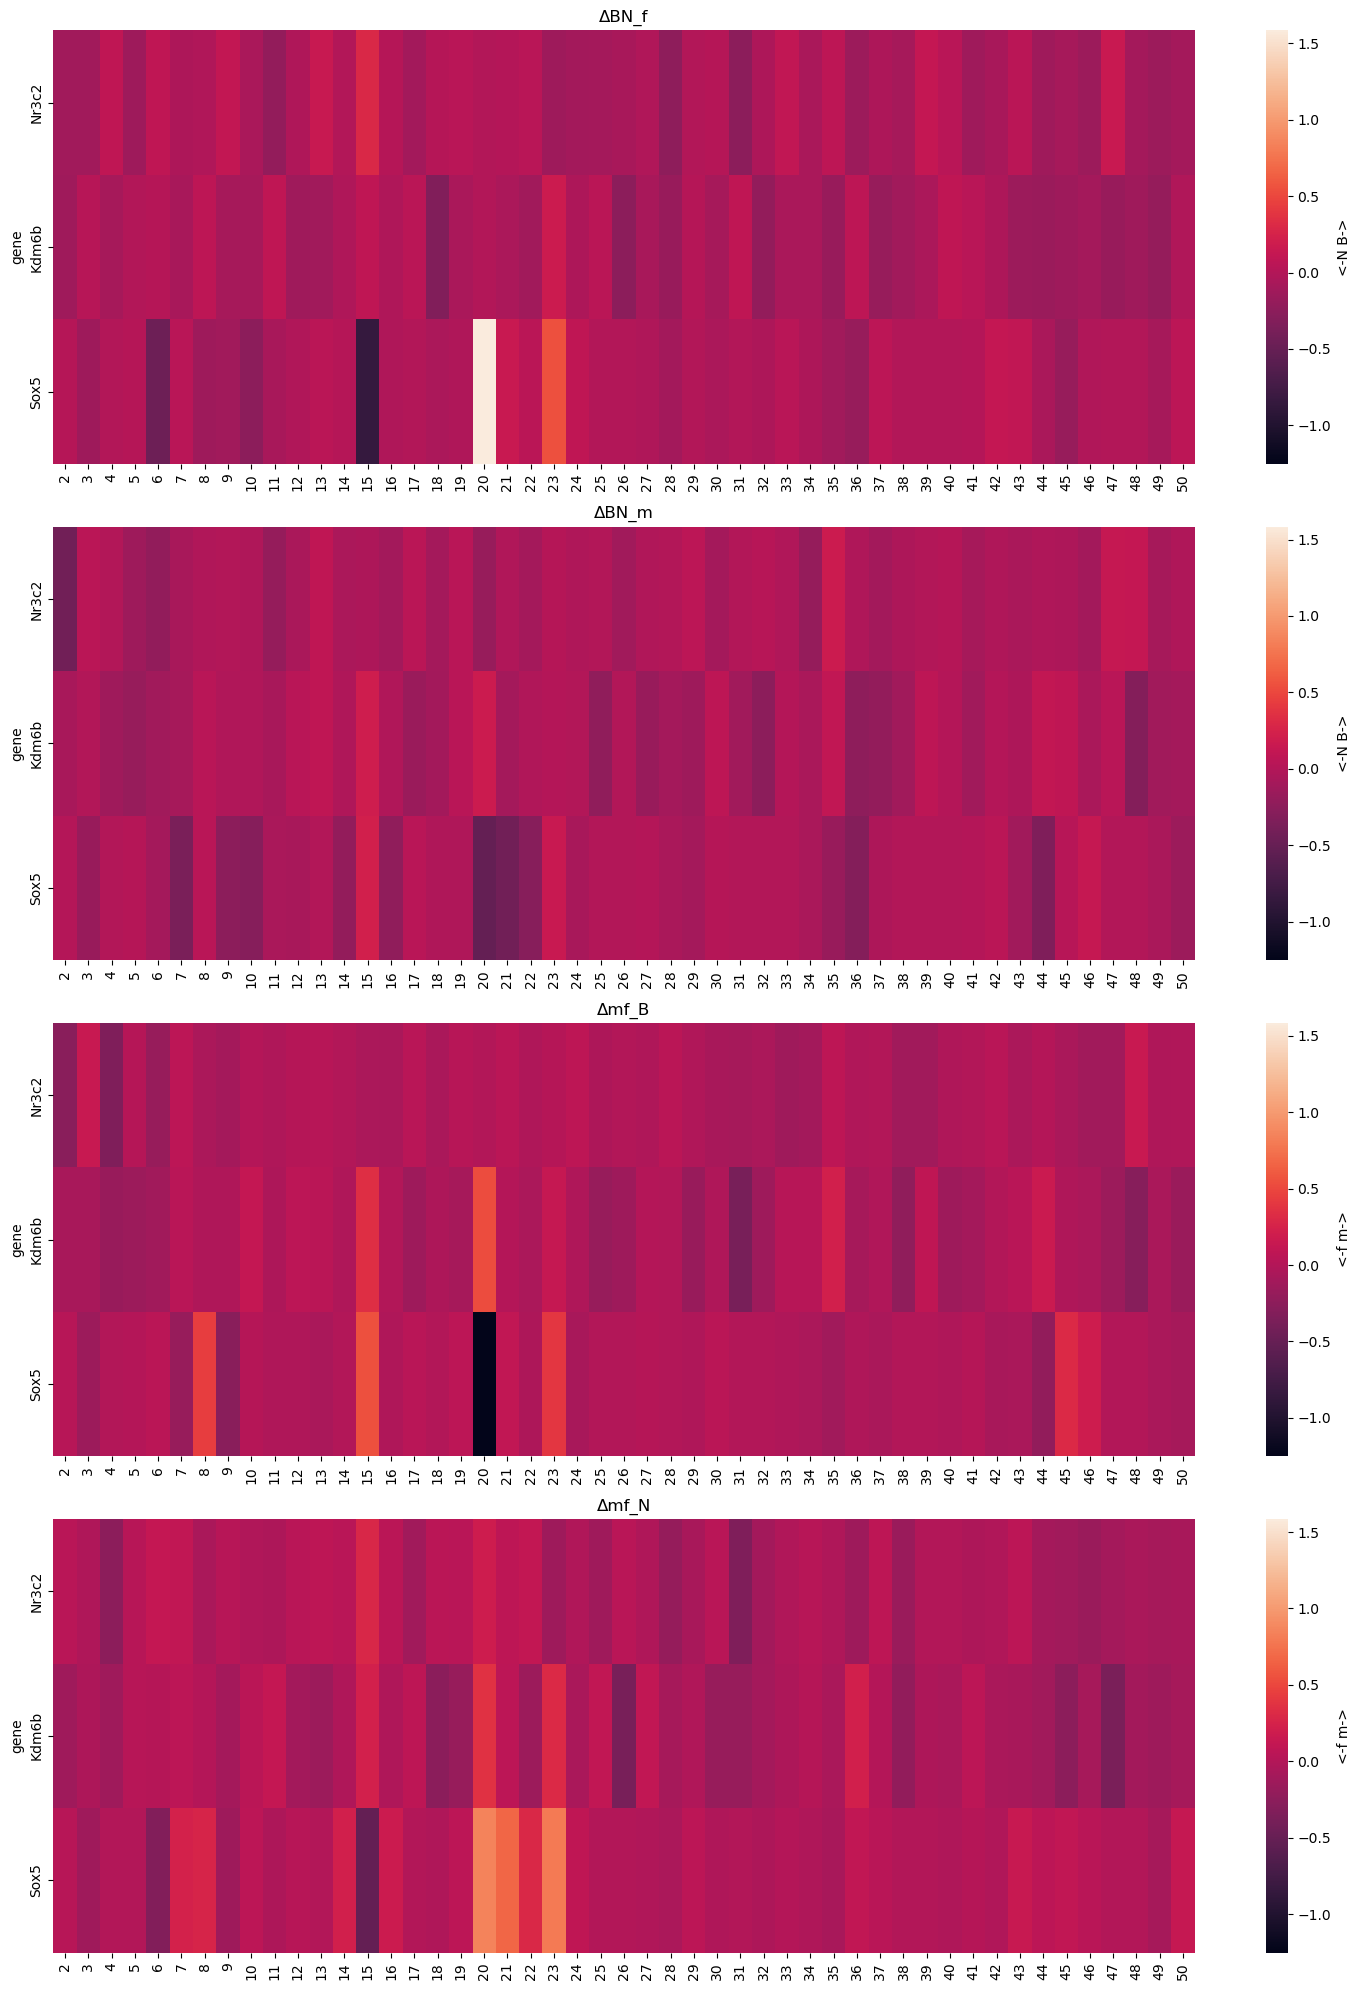

"\nfig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)  # Adjust height to fit all heatmaps\nvmin = gene_deltas.min().min()\nvmax = gene_deltas.max().max()\n\n# Plot each heatmap on its respective subplot\nfor i, ax in enumerate(axes):\n    # Set the title for each subplot\n    ax.set_title(ind_2_title_dict[i+1])\n    \n    # Plot the heatmap, selecting every 4th column starting at i for each subplot\n    sns.heatmap(gene_deltas.iloc[:, i::4], ax=ax, vmin=vmin, vmax=vmax, cbar=True)\n    ax.set_xticklabels(gene_deltas.iloc[:, ::4].columns.get_level_values(0))\n    ax.set_xlabel('')\n\n#plt.savefig(output_folder+'shah_asd_genes.png')\n# Show the entire figure with all 4 heatmaps\nplt.tight_layout()\nplt.show()\n"

In [1204]:
shah_asd_genes = ['Nr3c2','Kdm6b','Adnp','Mkx','Rorb','Sox5','Nr4a2']
intersected_gene_list = []
for g in shah_asd_genes:
    if g in tmp_fix_t_p_adj.index:
        intersected_gene_list.append(g)

gene_deltas = tmp_fix_t_p_adj.loc[intersected_gene_list].iloc[:,::2]
sga.plot_sig_gene_heatmap(gene_deltas,ind_2_title_dict,output_folder, outfile_name= 'shah_asd_genes', savefig = True)


# alternate approach using unique number of cell types for each sig gene

In [590]:
gaba_sig_deltas = gaba_sig_full.iloc[:,::2]
gaba_sig_p_adj = gaba_sig_full.iloc[:,1::2]

In [453]:
gaba_sig_deltas

Sncg-Htr3a                               Vip-Cbln2            \
                   delta                                   delta             
id                    2                                       3              
test               ΔBN_f     ΔBN_m     Δmf_B     Δmf_N     ΔBN_f     ΔBN_m   
gene                                                                         
0610007P14Rik  -0.089003 -0.081082 -0.042593 -0.050513 -0.017356 -0.219023   
0610009B22Rik  -0.311795 -0.274474  0.094533  0.057213 -0.207602 -0.177859   
0610010F05Rik   0.005795 -0.344001 -0.227545  0.122250  0.028714 -0.022957   
0610011F06Rik  -0.103439 -0.241604  0.042336  0.180500 -0.184100 -0.018922   
1110001J03Rik  -0.217839 -0.147887 -0.110370 -0.180321 -0.127906 -0.414141   
...                  ...       ...       ...       ...       ...       ...   
Zscan26        -0.079403 -0.195402 -0.116777 -0.000777 -0.066386 -0.132393   
Zyg11b         -0.228017 -0.619184 -0.369983  0.021183 -0.056526  0.087012   
Zzef1          -0.198463 -0.326248 -0.212695 -0.084910 -0.013876 -0.072957   
l7Rn6          -0.322910 -0.204682  0.058121 -0.060107 -0.229050 -0.063417   
mt-Nd6          0.017332  0.096368 -0.054857 -0.133893  0.052787  0.191485   

                                  Cpne4-Pde3a            ... Ptn-Ndst4  \
                                        delta            ...     delta   
id                                         4             ...        48   
test              Δmf_B     Δmf_N       ΔBN_f     ΔBN_m  ...     Δmf_B   
gene                                                     ...             
0610007P14Rik -0.318958 -0.117292   -0.735840  0.250000  ...  0.100178   
0610009B22Rik -0.003968 -0.033711   -0.166667  0.135213  ... -0.288859   
0610010F05Rik -0.058065 -0.006394   -0.083333 -0.406454  ... -0.125906   
0610011F06Rik  0.080675 -0.084503   -0.166667 -0.198120  ...  0.031683   
1110001J03Rik -0.237609  0.048627   -0.479574  0.083333  ...  0.160145   
...                 ...       ...         ...       ...  ...       ...   
Zscan26       -0.168242 -0.102235    0.083333 -0.360840  ...  0.198811   
Zyg11b         0.016509 -0.127030   -0.161759 -0.519815  ...  0.057806   
Zzef1         -0.104225 -0.045143    0.083333 -0.896241  ...  0.553534   
l7Rn6          0.120208 -0.045425   -0.166667 -0.058960  ... -0.153178   
mt-Nd6         0.130129 -0.008569    0.166667  0.163534  ...  0.246822   

                        Megf11-Gpc5                                \
                              delta                                 
id                               49                                 
test              Δmf_N       ΔBN_f     ΔBN_m     Δmf_B     Δmf_N   
gene                                                                
0610007P14Rik -0.301955   -0.346411 -0.170196  0.013051 -0.163165   
0610009B22Rik -0.040248   -0.193542 -0.062288  0.096048 -0.035206   
0610010F05Rik -0.060806   -0.521075 -0.220947  0.071048 -0.229080   
0610011F06Rik -0.403011   -0.009556 -0.104099  0.030991  0.125534   
1110001J03Rik -0.119076   -0.271105 -0.561373 -0.267514  0.022755   
...                 ...         ...       ...       ...       ...   
Zscan26       -0.084619   -0.214095 -0.313594 -0.206684 -0.107185   
Zyg11b        -0.319774   -0.718774 -0.521094 -0.156047 -0.353727   
Zzef1          0.067405   -0.310354 -0.643236 -0.191529  0.141352   
l7Rn6         -0.074537   -0.258632 -0.436634  0.051986  0.229988   
mt-Nd6        -0.030956    0.005672 -0.255984  0.072702  0.334358   

              BC048546-Dlx1                                
                      delta                                
id                       50                                
test                  ΔBN_f     ΔBN_m     Δmf_B     Δmf_N  
gene                                                       
0610007P14Rik     -0.489908 -0.457375 -0.121821 -0.154355  
0610009B22Rik     -0.430928  0.273235  0.332198 -0.371966  
0610010F05Rik     -0.033927 -0.351596 -0.061600  0.2560

In [452]:
gaba_sig_p_adj

Sncg-Htr3a                           Vip-Cbln2                  \
                   p_adj                               p_adj                   
id                    2                                   3                    
test               ΔBN_f     ΔBN_m     Δmf_B Δmf_N     ΔBN_f     ΔBN_m Δmf_B   
gene                                                                           
0610007P14Rik   0.997251  0.848014  1.000000   1.0       1.0  1.000000   1.0   
0610009B22Rik   0.433872  0.314746  1.000000   1.0       1.0  1.000000   1.0   
0610010F05Rik   1.000000  0.196966  0.821169   1.0       1.0  1.000000   1.0   
0610011F06Rik   0.987193  0.303367  1.000000   1.0       1.0  1.000000   1.0   
1110001J03Rik   0.740804  0.510642  1.000000   1.0       1.0  0.748092   1.0   
...                  ...       ...       ...   ...       ...       ...   ...   
Zscan26         1.000000  0.507378  0.982650   1.0       1.0  1.000000   1.0   
Zyg11b          0.917640  0.059060  0.743593   1.0       1.0  1.000000   1.0   
Zzef1           0.898447  0.185747  0.907614   1.0       1.0  1.000000   1.0   
l7Rn6           0.589918  0.493406  1.000000   1.0       1.0  1.000000   1.0   
mt-Nd6          1.000000  0.779667  1.000000   1.0       1.0  1.000000   1.0   

                    Cpne4-Pde3a        ... Ptn-Ndst4       Megf11-Gpc5  \
                          p_adj        ...     p_adj             p_adj   
id                           4         ...        48                49   
test          Δmf_N       ΔBN_f ΔBN_m  ...     Δmf_B Δmf_N       ΔBN_f   
gene                                   ...                               
0610007P14Rik   1.0         1.0   1.0  ...       1.0   1.0    0.037098   
0610009B22Rik   1.0         1.0   1.0  ...       1.0   1.0    0.229757   
0610010F05Rik   1.0         1.0   1.0  ...       1.0   1.0    0.003405   
0610011F06Rik   1.0         1.0   1.0  ...       1.0   1.0    0.920495   
1110001J03Rik   1.0         1.0   1.0  ...       1.0   1.0    0.125367   
...             ...         ...   ...  ...       ...   ...         ...   
Zscan26         1.0         1.0   1.0  ...       1.0   1.0    0.279020   
Zyg11b          1.0         1.0   1.0  ...       1.0   1.0    0.000166   
Zzef1           1.0         1.0   1.0  ...       1.0   1.0    0.121150   
l7Rn6           1.0         1.0   1.0  ...       1.0   1.0    0.139929   
mt-Nd6          1.0         1.0   1.0  ...       1.0   1.0    0.956915   

                                        BC048546-Dlx1                        
                                                p_adj                        
id                                                 50                        
test              ΔBN_m Δmf_B     Δmf_N         ΔBN_f     ΔBN_m Δmf_B Δmf_N  
gene                                                                         
0610007P14Rik  0.873183   1.0  1.000000      0.945025  0.289762   1.0   1.0  
0610009B22Rik  0.980275   1.0  1.000000      0.700084  0.571979   1.0   1.0  
0610010F05Rik  0.797098   1.0  1.000000      1.000000  0.524987   1.0   1.0  
0610011F06Rik  0.882264   1.0  1.000000      0.945025  0.566980   1.0   1.0  
1110001J03Rik  0.346130   1.0  1.000000      1.000000  0.228658   1.0   1.0  
...                 ...   ...       ...           ...       ...   ...   ...  
Zscan26        0.663440   1.0  1.000000      1.000000  0.837669   1.0   1.0  
Zyg11b         0.438580   1.0  0.862964      1.000000  0.043144   1.0   1.0  
Zzef1          0.251469   1.0  1.000000      1.000000  0.548164   1.0   1.0  
l7Rn6          0.473510   1.0  1.000000      1.000000  0.819944   1.0   1.0  
mt-Nd6         0.797530   1.0  0.862964      1.000000  0.989987   1.0   1.0  

[3629 rows x 196 columns]

In [773]:
cts_per_gene_df_uni_ct_sorted = sga.get_cts_per_gene(gaba_sig_p_adj,gaba_sig_deltas)

3629


In [769]:
cts_per_gene_df_uni_ct_sorted

,ct,unique_cts,unique_cts_counts
gene,,,
Eid2,"[Sncg-Htr3a, Reln-Ndnf, Dab1-Nfib, Kit-Pdlim5,...","[Calca, Calcr-Peg10, Col11a1-Pde11a, Col23a1, ...",31
Pin1,"[Sncg-Htr3a, Reln-Ndnf, Reln-Ndnf, Kit-Pdlim5,...","[BC048546-Dlx1, Calca, Calcr-Peg10, Cbln1-Grp,...",26
Gm10076,"[Sncg-Htr3a, Vip-Cbln2, Vip-Cbln2, Reln-Ndnf, ...","[Calcr-Peg10, Cbln1-Grp, Col11a1-Pde11a, Col23...",25
Slc24a5,"[Sncg-Htr3a, Reln-Ndnf, Dab1-Nfib, Kit-Pdlim5,...","[Calcr-Peg10, Cbln1-Grp, Col11a1-Pde11a, Col23...",24
Lamtor5,"[Sncg-Htr3a, Reln-Ndnf, Reln-Ndnf, Kit-Pdlim5,...","[BC048546-Dlx1, Calcr-Peg10, Cbln1-Grp, Col11a...",24
...,...,...,...
Etfb,[Igfbp6-Rprm],[Igfbp6-Rprm],1
Esrra,[Rbp4-Kitl],[Rbp4-Kitl],1
Faap20,[Unc13c-Crtac1],[Unc13c-Crtac1],1


In [647]:
np.where(cts_per_gene_df_uni_ct_sorted.index == 'Esr1')

(array([1777]),)

In [648]:
np.where(cts_per_gene_df_uni_ct_sorted.index == 'Ar')

(array([583]),)

In [649]:
np.where(cts_per_gene_df_uni_ct_sorted.index == 'Prlr')

(array([547]),)

In [650]:
intersected_chen_list

['Socs2', 'Greb1', 'Fam84a']

In [651]:
for g in intersected_chen_list:
    print (g, np.where(cts_per_gene_df_uni_ct_sorted.index == g))

Socs2 (array([492]),)
Greb1 (array([911]),)
Fam84a (array([1708]),)


In [611]:
#get gene onthology using https://davidbioinformatics.nih.gov/conversion.jsp?VFROM=NA, pasting gene list below
", ".join(cts_per_gene_df_uni_ct_sorted.index[:100])

'Eid2, Pin1, Gm10076, Slc24a5, Lamtor5, Mrpl43, Dlg4, Yaf2, Fam92a, Cct2, Cdkn2d, B3gat3, Emc6, Map1lc3b, Rab12, Ccnt2, BC031181, Chchd1, Lsm4, Aurkaip1, H1fx, Hnrnph1, Mrpl12, Rbm3, Dynlt3, Rnf10, Strap, Arl6ip5, Tmem158, Smim14, Zfp638, Cct5, Ralyl, Txnl1, Ntan1, Mrpl11, Suclg1, Mien1, Snrpd3, Srp19, Timm10, Lysmd2, Psma1, Arhgdig, Coprs, Mrps36, Ola1, Ankrd17, Cab39, Ndufs4, Ttc9b, Mrpl41, Hn1, Ssbp4, 1110065P20Rik, Psmb6, Ppm1a, Arhgap5, Mrps16, Sf3b5, Hist3h2ba, Tomm5, Uba52, Anapc5, Sdhaf4, Lamtor4, Lamtor1, Fam195b, Rb1cc1, Mrps17, Cdc42bpa, Gmps, Tmem167, Dtd1, Chmp5, Psma2, Pmm1, Matk, Herc1, Pten, Higd1a, Tmem147, Psd, Dock3, Akirin2, Wdfy3, Krit1, Ncs1, Hmgn3, Sin3b, Ngrn, Ube2e1, Tmem91, Ranbp1, Ntrk3, Ube2e2, Ptp4a1, Elof1, Fam49b, Psmb4'

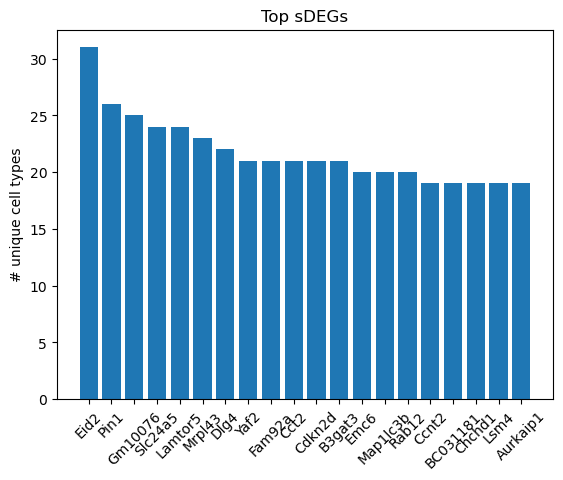

In [625]:
subset = 20
fig,ax = plt.subplots()
#plt.plot(cts_per_gene_df_uni_ct_sorted['unique_cts_counts'][:subset], '.')
#ax.set_xticklabels(cts_per_gene_df_uni_ct_sorted.index[:subset])
plt.bar(x = cts_per_gene_df_uni_ct_sorted.index[:subset],height=cts_per_gene_df_uni_ct_sorted['unique_cts_counts'][:subset])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('# unique cell types')
ax.set_title('Top sDEGs')
plt.show()

In [595]:
gaba_sig_deltas.reindex(index = cts_per_gene_df_uni_ct_sorted.index)

Sncg-Htr3a                               Vip-Cbln2            \
             delta                                   delta             
id              2                                       3              
test         ΔBN_f     ΔBN_m     Δmf_B     Δmf_N     ΔBN_f     ΔBN_m   
gene                                                                   
Eid2     -0.468140 -0.653029  0.105810  0.290699 -0.367703 -0.555421   
Pin1     -0.247611 -0.748381 -0.253675  0.247095 -0.060308  0.025863   
Gm10076   0.613456  0.048701  0.783740  1.348495  0.400240  1.002566   
Slc24a5  -0.770864 -0.266501  0.286770 -0.217592 -0.544287 -0.283459   
Lamtor5  -0.400582 -0.661485 -0.051713  0.209190 -0.199107 -0.437537   
...            ...       ...       ...       ...       ...       ...   
Etfb     -0.025163 -0.236388 -0.026760  0.184466 -0.000251 -0.127542   
Esrra    -0.025516 -0.057587 -0.015395  0.016675 -0.009521  0.024632   
Faap20   -0.134095 -0.158792 -0.159124 -0.134428  0.049478 -0.078513   
Faah     -0.028608 -0.016951 -0.017879 -0.029536  0.062569 -0.029298   
Ero1l    -0.130786 -0.082266  0.025890 -0.022630 -0.071679  0.190650   

                            Cpne4-Pde3a            ... Ptn-Ndst4            \
                                  delta            ...     delta             
id                                   4             ...        48             
test        Δmf_B     Δmf_N       ΔBN_f     ΔBN_m  ...     Δmf_B     Δmf_N   
gene                                               ...                       
Eid2    -0.042866  0.144852   -0.413815 -0.166667  ... -0.016815 -0.206691   
Pin1    -0.041242 -0.127413   -0.062907 -0.396241  ... -0.701441  0.195092   
Gm10076  1.050713  0.448386    0.815386 -0.333333  ...  1.277201  1.248849   
Slc24a5  0.144322 -0.116506   -0.872963 -0.149655  ... -0.169310 -0.243996   
Lamtor5 -0.209572  0.028857   -0.977286 -0.995442  ... -0.104859  0.002323   
...           ...       ...         ...       ...  ...       ...       ...   
Etfb    -0.114703  0.012588    0.000000 -0.125000  ...  0.018182 -0.202480   
Esrra    0.041142  0.006988    0.333333 -0.125000  ... -0.053862 -0.042585   
Faap20  -0.156746 -0.028755   -0.250000 -0.625000  ... -0.118182 -0.250918   
Faah    -0.051736  0.040131   -0.479574 -0.198120  ... -0.299316 -0.039824   
Ero1l    0.199916 -0.062412    0.430827 -0.771241  ... -0.522357 -0.242253   

        Megf11-Gpc5                               BC048546-Dlx1            \
              delta                                       delta             
id               49                                          50             
test          ΔBN_f     ΔBN_m     Δmf_B     Δmf_N         ΔBN_f     ΔBN_m   
gene                                                                        
Eid2      -0.789950 -0.679218  0.273800  0.163067     -0.745297 -0.593452   
Pin1      -0.526760 -0.162698  0.111719 -0.252342     -0.286731 -0.773083   
Gm10076   -0.056035  0.033544  1.323285  1.233706     -0.030932 -0.342880   
Slc24a5   -0.585536 -0.210980  0.225348 -0.149208     -0.706276 -0.528776   
Lamtor5   -0.536410 -1.016245 -0.401175  0.078659     -0.368914 -1.086813   
...             ...       ...       ...       ...           ...       ...   
Etfb      -0.172940 -0.135098  0.040860  0.003018     -0.240824 -0.146606   
Esrra     -0.072133 -0.356797 -0.343280 -0.058617     -0.095081 -0.062857   
Faap20    -0.096013 -0.424935 -0.301480  0.027441     -0.051124 -0.115177   
Faah      -0.203598 -0.047549 -0.028482 -0.184531      0.127358  0.055901   
Ero1l     -0.370923 -0.223236 -0.050154 -0.197842     -0.003993 -0.034636   

                             
                             
id                           
test        Δmf_B     Δmf_N  
gene                         
Eid2     0.318278  0.166434  
Pin1    -0.318638  0.167714  
Gm10076  0.287093  0.599041  
Slc24a5 -0.120774 -0.298274  
Lamtor5 -0.530114  0.187784  
...           ...       ...  
Etfb     0.001898 -0.092320  
Esrra   -0.16

In [614]:
output_folder

'/bigdata/isaac/gaba_files/sex_stats/volcano_plots/081124_run/sig_gene_heatmaps/'

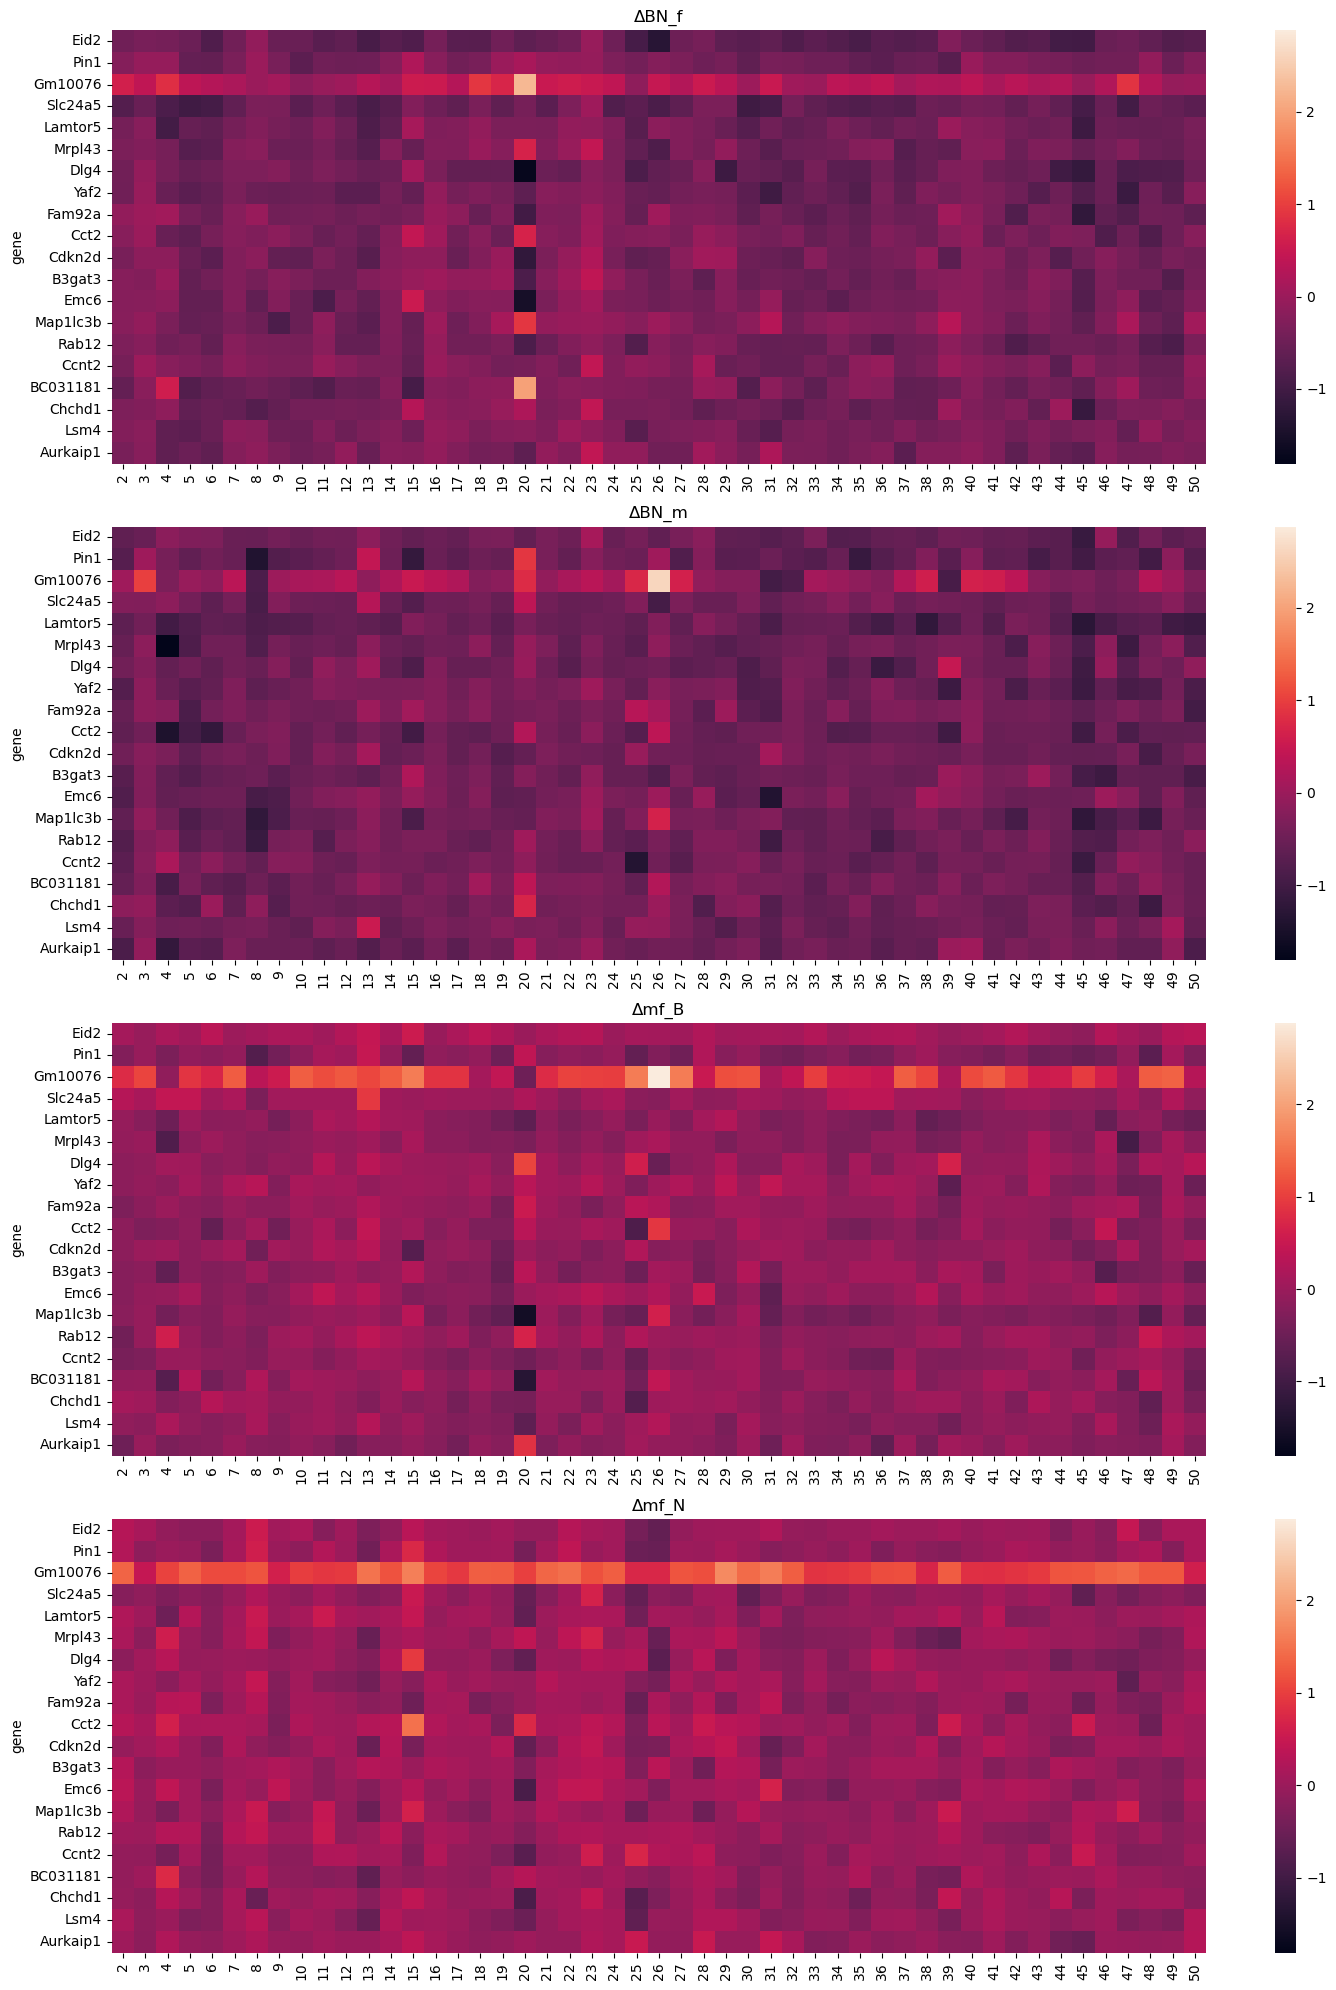

In [613]:
plot_sig_gene_heatmap(gaba_sig_deltas.reindex(index = cts_per_gene_df_uni_ct_sorted.index)[:subset],ind_2_title_dict,output_folder, outfile_name= 'cts_per_gene_df_uni_ct_sorted_heatmap',savefig = True)

# Repeat but isolated for each test

In [635]:
gaba_sig_deltas_ΔBN_f = gaba_sig_deltas.iloc[:,::4]
gaba_sig_p_adj_ΔBN_f = gaba_sig_p_adj.iloc[:,::4]


In [655]:
gaba_sig_deltas_ΔBN_m = gaba_sig_deltas.iloc[:,1::4]
gaba_sig_p_adj_ΔBN_m = gaba_sig_p_adj.iloc[:,1::4]

In [661]:
gaba_sig_deltas_Δmf_B = gaba_sig_deltas.iloc[:,2::4]
gaba_sig_p_adj_Δmf_B = gaba_sig_p_adj.iloc[:,2::4]

In [665]:
gaba_sig_deltas_Δmf_N = gaba_sig_deltas.iloc[:,3::4]
gaba_sig_p_adj_Δmf_N = gaba_sig_p_adj.iloc[:,3::4]

In [774]:
cts_per_gene_df_uni_ct_sorted_ΔBN_f = sga.get_cts_per_gene(gaba_sig_p_adj_ΔBN_f,gaba_sig_deltas_ΔBN_f)
cts_per_gene_df_uni_ct_sorted_ΔBN_m = sga.get_cts_per_gene(gaba_sig_p_adj_ΔBN_m,gaba_sig_deltas_ΔBN_m)
cts_per_gene_df_uni_ct_sorted_Δmf_B = sga.get_cts_per_gene(gaba_sig_p_adj_Δmf_B,gaba_sig_deltas_Δmf_B)
cts_per_gene_df_uni_ct_sorted_Δmf_N = sga.get_cts_per_gene(gaba_sig_p_adj_Δmf_N,gaba_sig_deltas_Δmf_N)

2812
2579
405
189


In [668]:
ind_2_title_dict

{1: 'ΔBN_f', 2: 'ΔBN_m', 3: 'Δmf_B', 4: 'Δmf_N'}

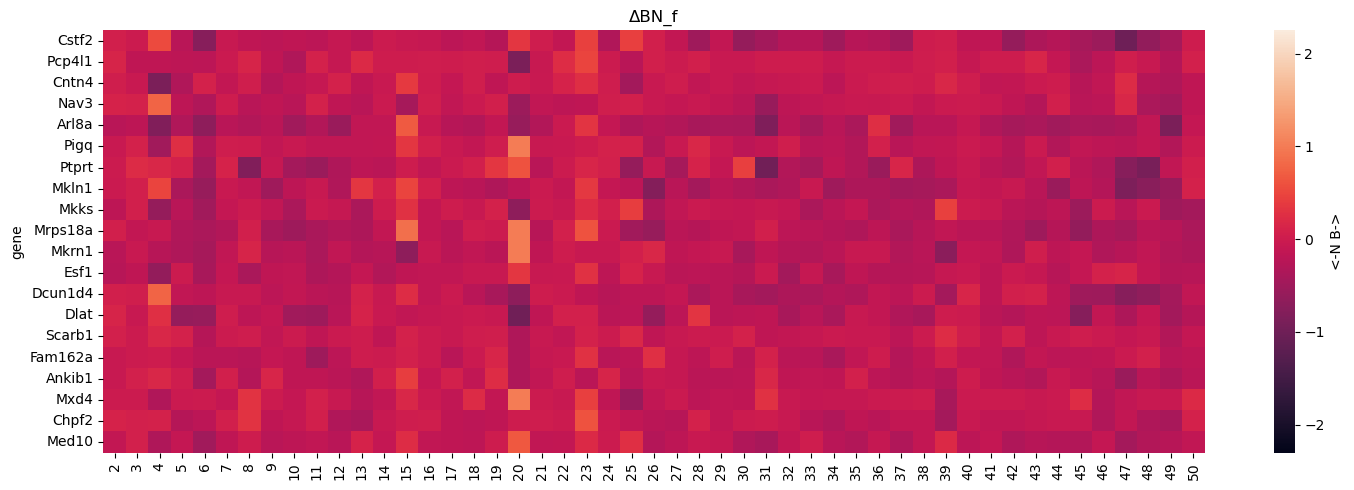

In [1188]:
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_f.reindex(index = cts_per_gene_df_uni_ct_sorted_ΔBN_f.index),
                         ind_2_title_dict[1],
                         20,
                        output_folder,
                         'BN_f_cts_per_gene_df_uni_ct_sorted_heatmap',
                         savefig = True)

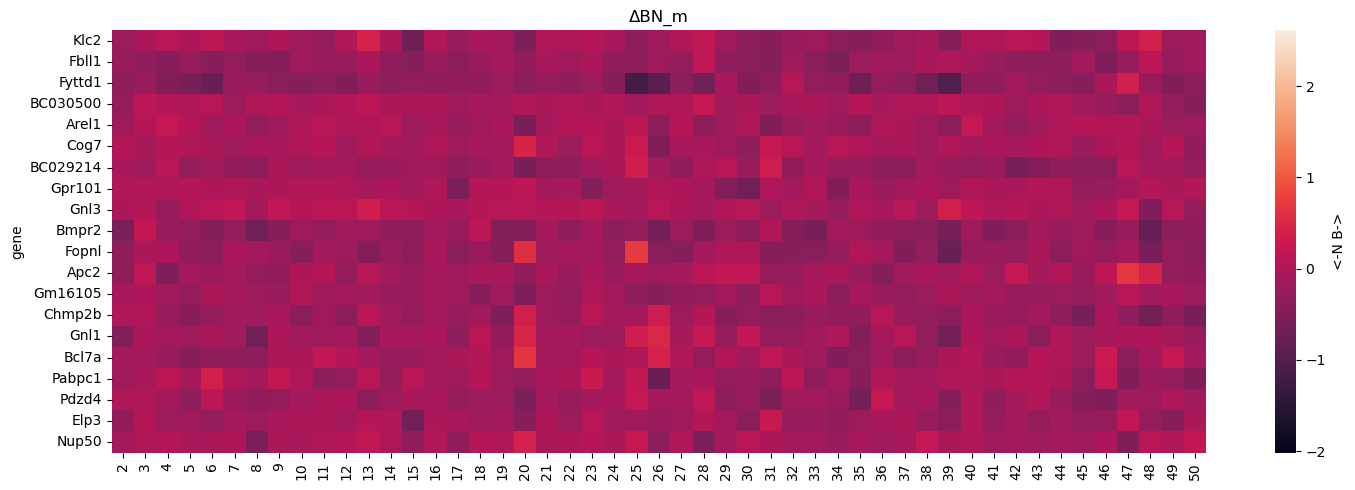

In [1187]:
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_m.reindex(index = cts_per_gene_df_uni_ct_sorted_ΔBN_m.index),
                         ind_2_title_dict[2],
                        20,
                        output_folder,
                         'BN_m_cts_per_gene_df_uni_ct_sorted_heatmap',
                         savefig = True)

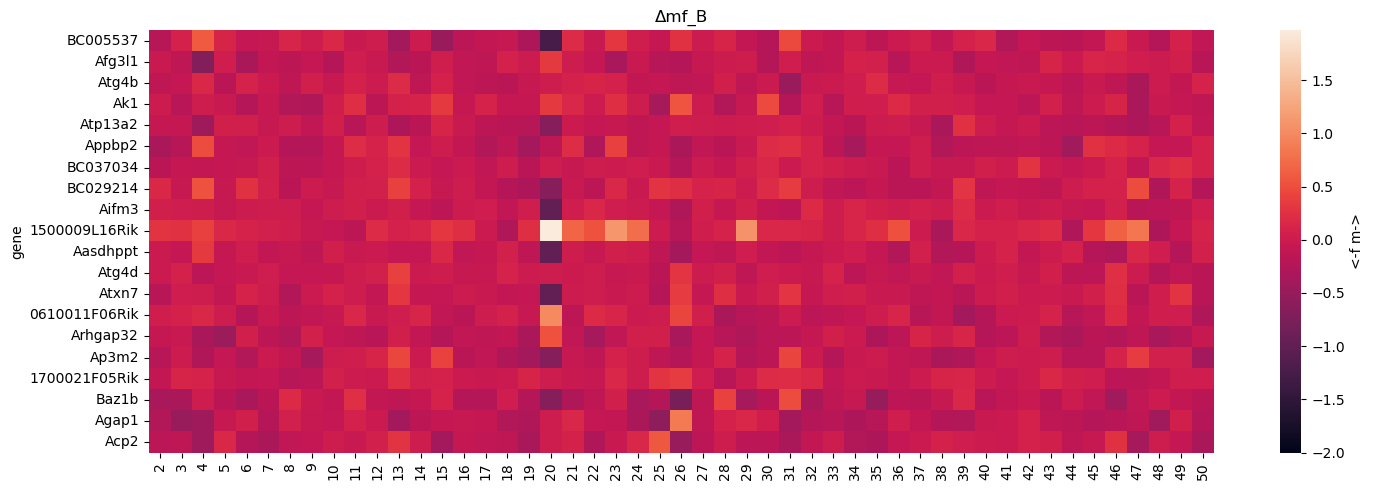

In [1186]:
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_B.reindex(index = cts_per_gene_df_uni_ct_sorted_Δmf_B.index),
                         ind_2_title_dict[3],
                        20,
                        output_folder,
                         'mf_B_cts_per_gene_df_uni_ct_sorted_heatmap',
                         savefig = True)

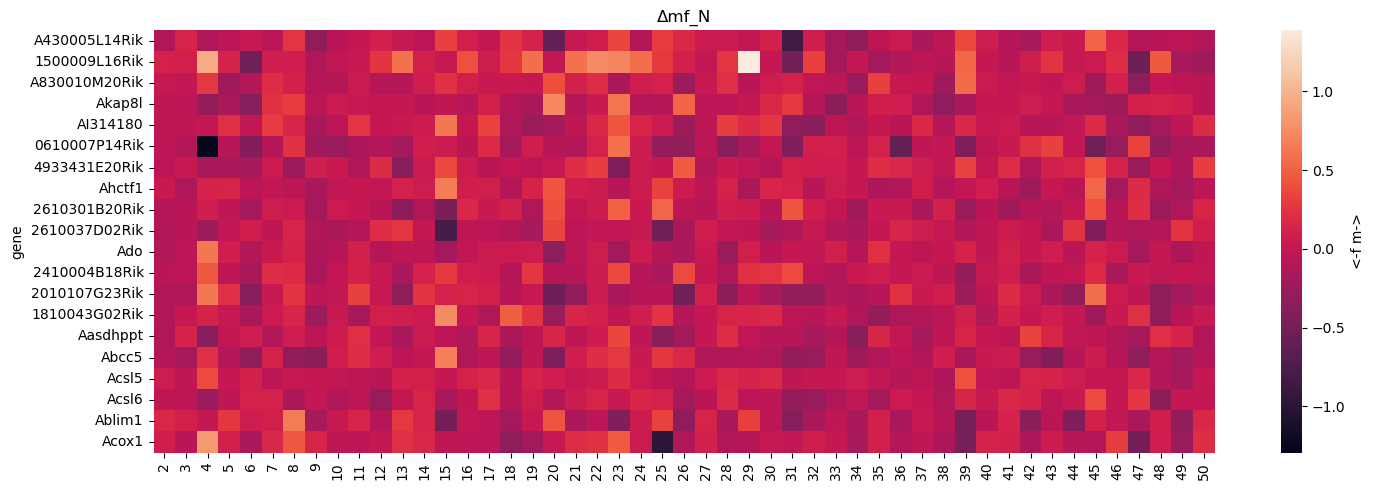

In [1185]:
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_N.reindex(index = cts_per_gene_df_uni_ct_sorted_Δmf_N.index),
                         ind_2_title_dict[4],
                        20,
                        output_folder,
                         'mf_N_cts_per_gene_df_uni_ct_sorted_heatmap',
                         savefig = True)

In [771]:
", ".join(cts_per_gene_df_uni_ct_sorted_Δmf_N.index[:100])

'A430005L14Rik, 1500009L16Rik, A830010M20Rik, Akap8l, AI314180, 0610007P14Rik, 4933431E20Rik, Ahctf1, 2610301B20Rik, 2610037D02Rik, Ado, 2410004B18Rik, 2010107G23Rik, 1810043G02Rik, Aasdhppt, Abcc5, Acsl5, Acsl6, Ablim1, Acox1, 2810428I15Rik, Afap1, Acsl3, Acot7, Acbd5, A330102I10Rik, Acadsb, Actr2, Adgrb2, Adam23, Adgra1, Adar, Add2, AK010878, AW549877, Aamdc, Abca2, Adcy5, A830039N20Rik, 0610010F05Rik, Ak1, Aig1, Aifm3, Akap5, Ahsa2, 1700020I14Rik, 1110032A03Rik, 1810041L15Rik, 6330403A02Rik, 2300009A05Rik, 2310035C23Rik, 1110008P14Rik, 2410002F23Rik, Ahcyl1, 1810058I24Rik, 2700029M09Rik, Agk, Adcy1, Adarb2, Akt1, Adarb1, Ahsa1, Adap1, Agl, Adam22, Adam11, Acyp1, Actr3b, Actr3, 1500009C09Rik, Ago2, Actr1b, Actr10, Actl6b, Ago3, Agpat1, Agpat3, Aip, Acsl4, 0610009B22Rik, Acsl1, Acp2, Agpat4, Aida, Aen, Aebp2, Adss, Adrm1, Adrbk2, Adra2c, Adra2a, Adra1a, Adprhl2, Ahcyl2, Ahdc1, 1110002L01Rik, Adh5, 1110065P20Rik, Adgrl2, Afg3l1'

/tmp/ipykernel_825485/384306299.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=90)
/tmp/ipykernel_825485/384306299.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=90)
/tmp/ipykernel_825485/384306299.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1,0].set_xticklabels(axs[-1,0].get_xticklabels(), rotation=90)
/tmp/ipykernel_825485/384306299.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,-1].set_xticklabels(axs[1,-1].get_xticklabels(), rotation=90)


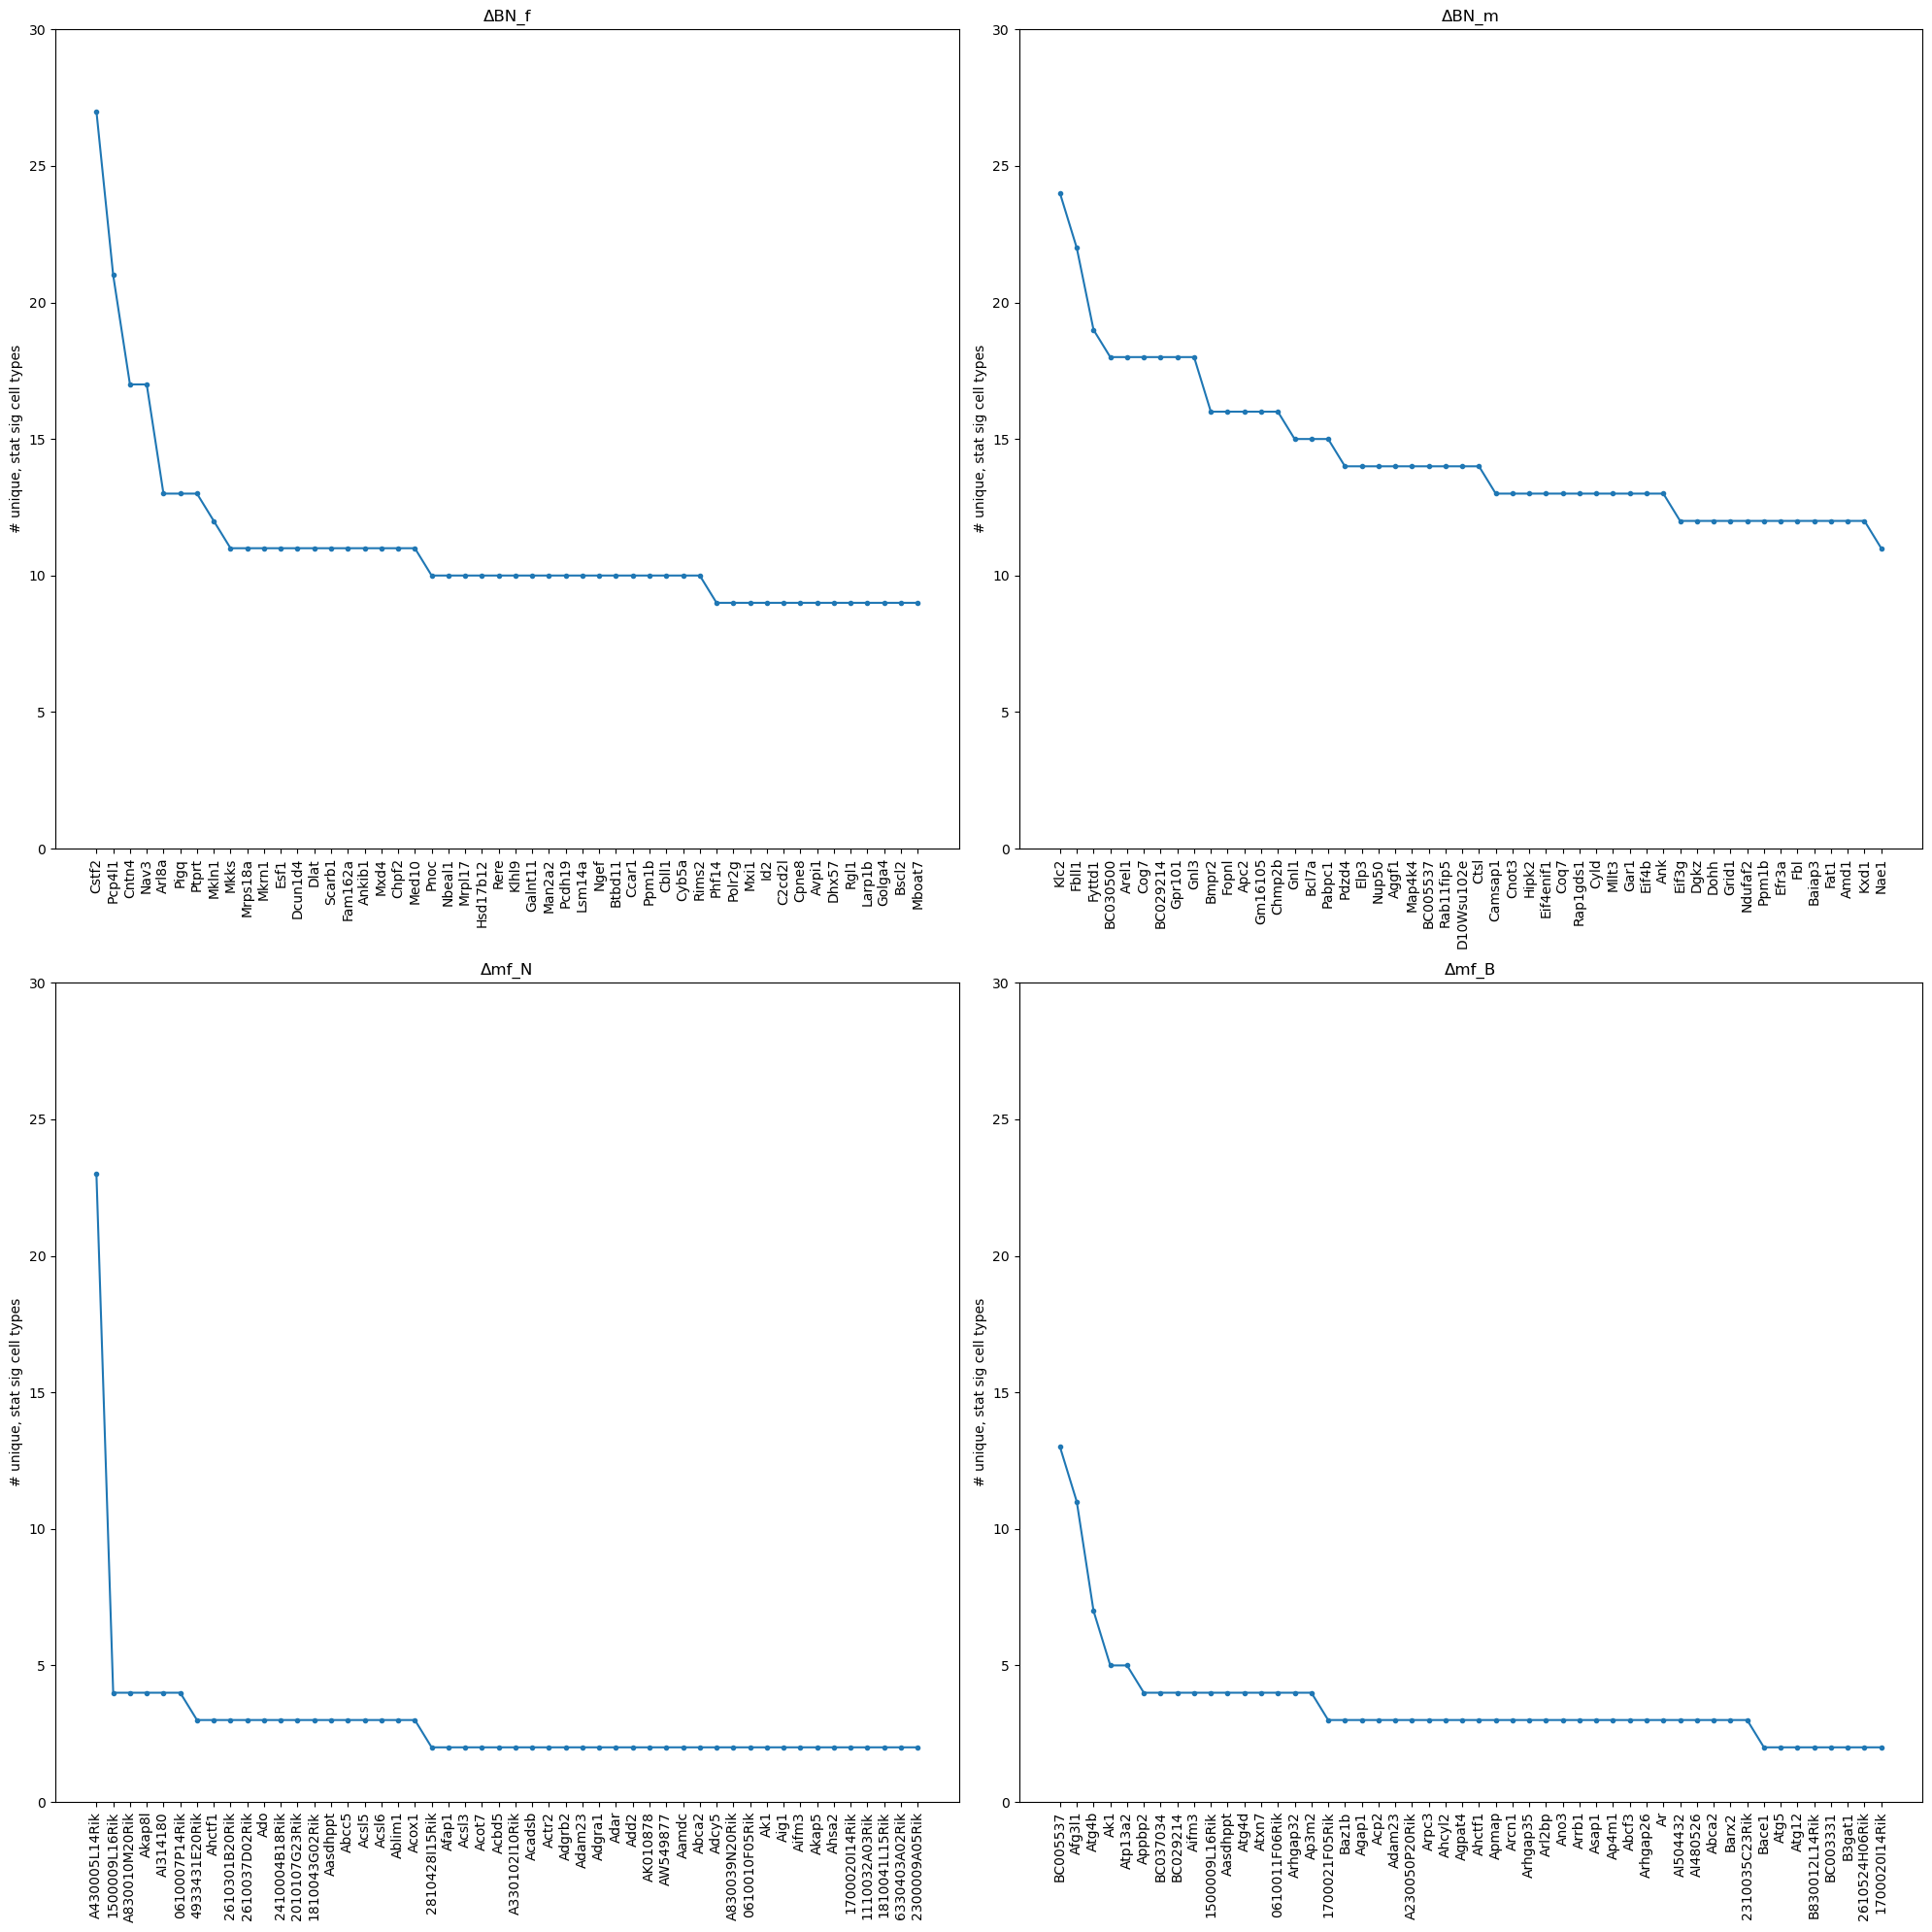

In [879]:
%matplotlib inline
fig,axs = plt.subplots(2,2, figsize = (20,20))
plt.xticks(rotation = 90)
axs[0,0].set_title('ΔBN_f')
axs[0,0].plot(cts_per_gene_df_uni_ct_sorted_ΔBN_f['unique_cts_counts'][:50], '.-')
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=90)
axs[0,0].set_ylim([0,30])
axs[0,0].set_ylabel('# unique, stat sig cell types')


axs[0,1].set_title('ΔBN_m')
axs[0,1].plot(cts_per_gene_df_uni_ct_sorted_ΔBN_m['unique_cts_counts'][:50], '.-')
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=90)
axs[0,1].set_ylim([0,30])
axs[0,1].set_ylabel('# unique, stat sig cell types')

axs[-1,0].set_title('Δmf_N')
axs[-1,0].plot(cts_per_gene_df_uni_ct_sorted_Δmf_N['unique_cts_counts'][:50], '.-')
axs[-1,0].set_xticklabels(axs[-1,0].get_xticklabels(), rotation=90)
axs[-1,0].set_ylim([0,30])
axs[-1,0].set_ylabel('# unique, stat sig cell types')

axs[1,-1].set_title('Δmf_B')
axs[1,-1].plot(cts_per_gene_df_uni_ct_sorted_Δmf_B['unique_cts_counts'][:50], '.-')
axs[1,-1].set_xticklabels(axs[1,-1].get_xticklabels(), rotation=90)
axs[1,-1].set_ylim([0,30])
axs[1,-1].set_ylabel('# unique, stat sig cell types')

plt.savefig(output_folder+'unique_num_cell_types_sorted_each_group'+'.png')

plt.tight_layout()
plt.show()

In [880]:
output_folder

'/bigdata/isaac/gaba_files/sex_stats/volcano_plots/081124_run/sig_gene_heatmaps/'

## Alternate approach for finding key genes
### Use p-value dataframe to get mask where alpha < 0.05, use mask to filter corresponding delta (FC) dataframe, take
### max of abs value for each gene, and sort gene index high to low

In [1154]:
ind_2_title_dict[1]

'ΔBN_f'

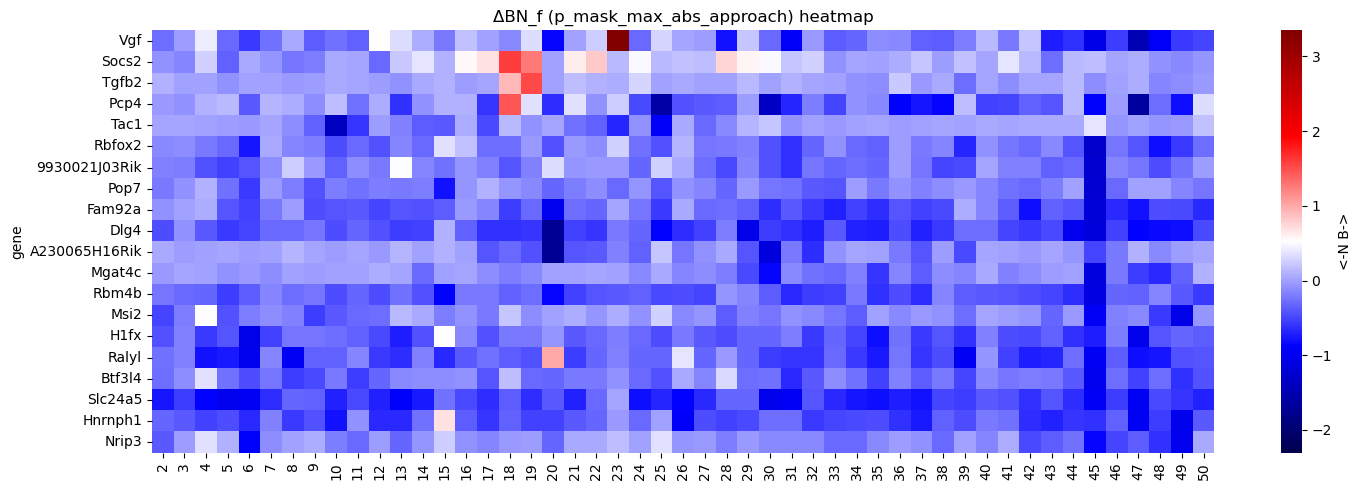

In [1206]:
%matplotlib inline
gene_list_fc_p_mask_max_abs_ΔBN_f = sga.p_mask_max_abs(gaba_sig_p_adj_ΔBN_f,gaba_sig_deltas_ΔBN_f)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_f.reindex(index= gene_list_fc_p_mask_max_abs_ΔBN_f.index),
                         ind_2_title_dict[1] + ' (p_mask_max_abs_approach) heatmap',
                        20,
                        output_folder,
                        ind_2_title_dict[1] + ' (p_mask_max_abs_approach) heatmap',
                         savefig = True)

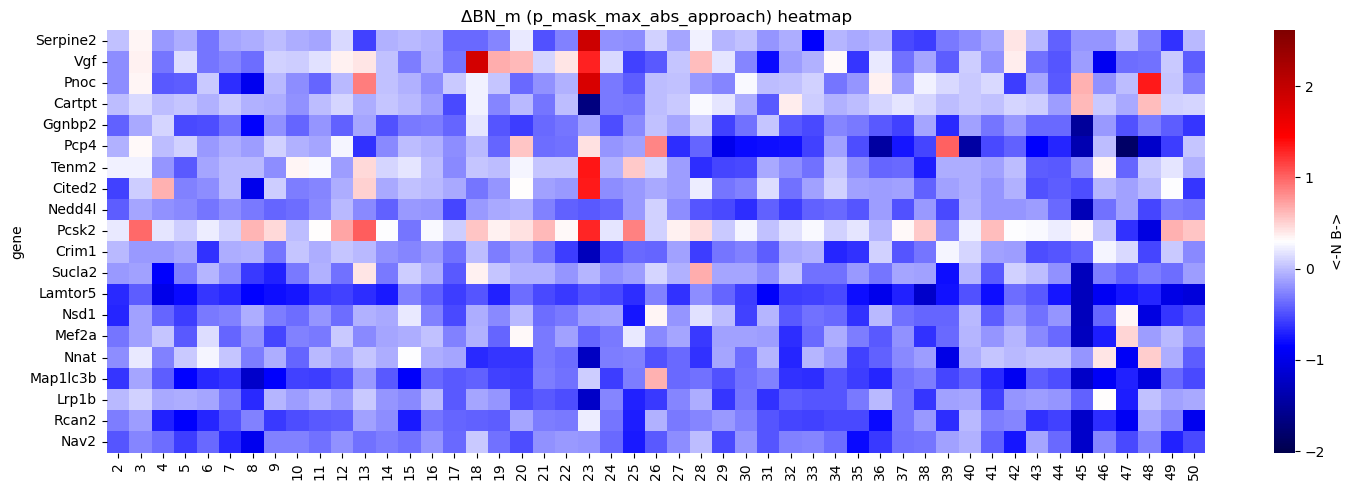

In [1207]:
gene_list_fc_p_mask_max_abs_ΔBN_m = sga.p_mask_max_abs(gaba_sig_p_adj_ΔBN_m,gaba_sig_deltas_ΔBN_m)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_ΔBN_m.reindex(index= gene_list_fc_p_mask_max_abs_ΔBN_m.index),
                         ind_2_title_dict[2] + ' (p_mask_max_abs_approach) heatmap',
                        20,
                        output_folder,
                         ind_2_title_dict[2] + ' (p_mask_max_abs_approach) heatmap',
                         savefig = True)

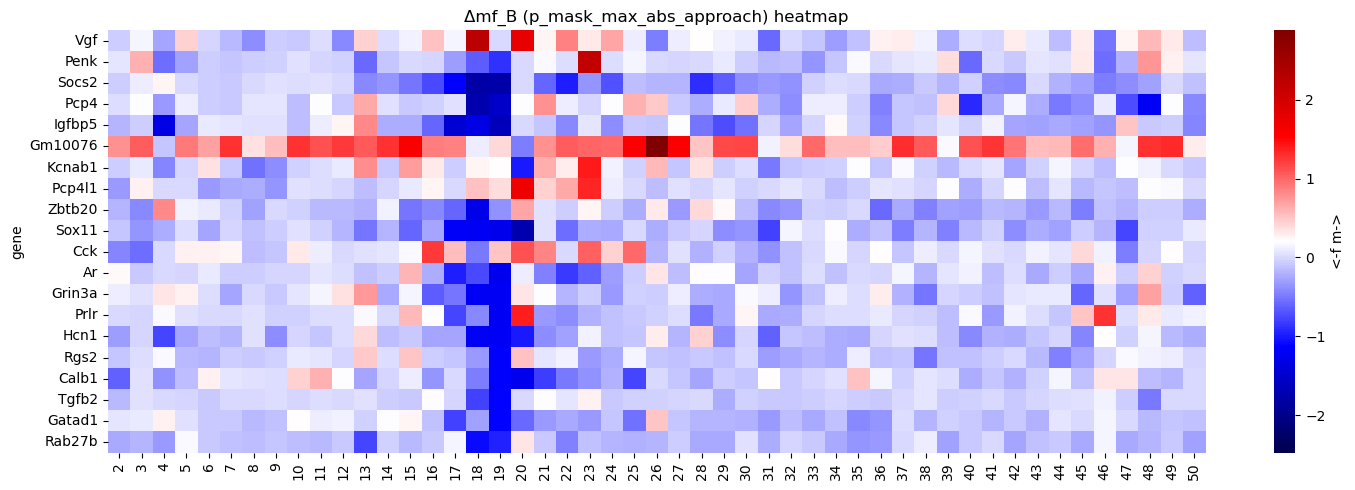

In [1208]:
gene_list_fc_p_mask_max_abs_Δmf_B = sga.p_mask_max_abs(gaba_sig_p_adj_Δmf_B,gaba_sig_deltas_Δmf_B)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index),
                         ind_2_title_dict[3] + ' (p_mask_max_abs_approach) heatmap',
                        20,
                        output_folder,
                         ind_2_title_dict[3] + ' (p_mask_max_abs_approach) heatmap',
                         savefig = True)

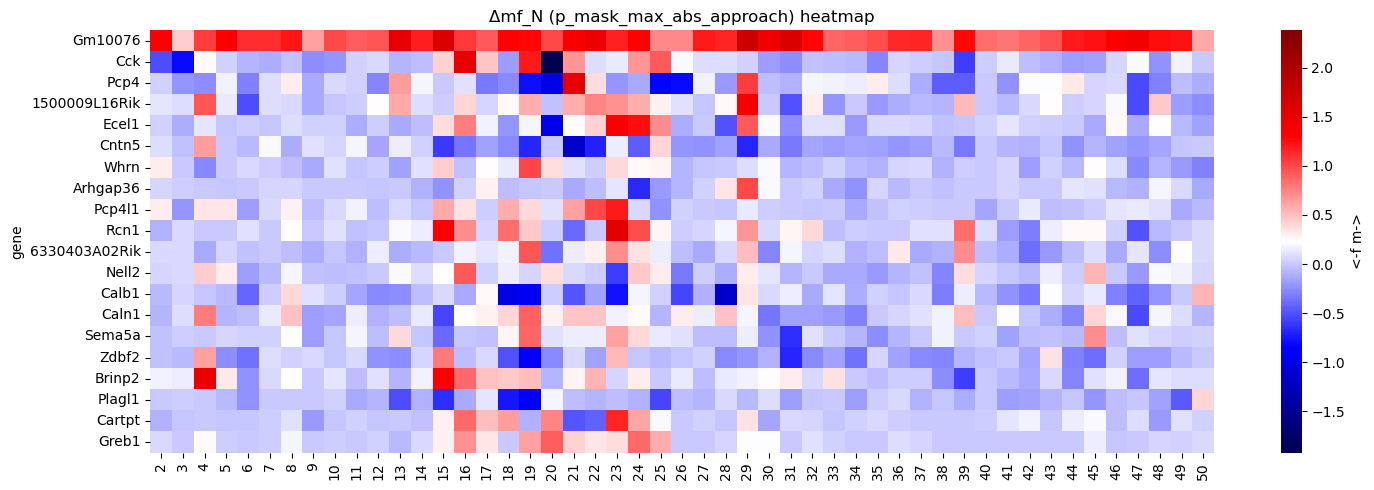

In [1209]:
gene_list_fc_p_mask_max_abs_Δmf_N = sga.p_mask_max_abs(gaba_sig_p_adj_Δmf_N,gaba_sig_deltas_Δmf_N)
sga.plot_sig_gene_heatmap_igi(gaba_sig_deltas_Δmf_N.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_N.index),
                         ind_2_title_dict[4] + ' (p_mask_max_abs_approach) heatmap',
                        20,
                        output_folder,
                         ind_2_title_dict[4] + ' (p_mask_max_abs_approach) heatmap',
                         savefig = True)

In [1216]:
", ".join(gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index).index[:10])

'Vgf, Penk, Socs2, Pcp4, Igfbp5, Gm10076, Kcnab1, Pcp4l1, Zbtb20, Sox11'

## Union of mf_N/B

In [1211]:
gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index).index

Index(['Vgf', 'Penk', 'Socs2', 'Pcp4', 'Igfbp5', 'Gm10076', 'Kcnab1', 'Pcp4l1',
       'Zbtb20', 'Sox11',
       ...
       'Gigyf2', 'Gipc1', 'Gkap1', 'Gle1', 'Glo1', 'Glod4', 'Glrb', 'Glrx',
       'Glrx2', 'Gga2'],
      dtype='object', name='gene', length=3629)

In [ ]:
union_mf = [for i,j in zip(gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index).index,gaba_sig_deltas_Δmf_N.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_N.index).index

In [1214]:
union_mf = (gaba_sig_deltas_Δmf_B.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_B.index).index + gaba_sig_deltas_Δmf_N.reindex(index= gene_list_fc_p_mask_max_abs_Δmf_N.index).index)

In [1215]:
union_mf

Index(['VgfGm10076', 'PenkCck', 'Socs2Pcp4', 'Pcp41500009L16Rik',
       'Igfbp5Ecel1', 'Gm10076Cntn5', 'Kcnab1Whrn', 'Pcp4l1Arhgap36',
       'Zbtb20Pcp4l1', 'Sox11Rcn1',
       ...
       'Gigyf2Fut9', 'Gipc1Fxyd7', 'Gkap1Fyco1', 'Gle1Fyn', 'Glo1Fyttd1',
       'Glod4Fzr1', 'GlrbG3bp1', 'GlrxGabbr2', 'Glrx2Gabra3', 'Gga2Fuca1'],
      dtype='object', name='gene', length=3629)

In [908]:
ind_2_ct_dict = dict(zip(np.arange(0,len(gaba_sig_p_adj_Δmf_B.columns)),np.array(gaba_sig_p_adj_Δmf_B.columns.get_level_values(0))))

In [909]:
ind_2_ct_dict

{0: 'Sncg-Htr3a',
 1: 'Vip-Cbln2',
 2: 'Cpne4-Pde3a',
 3: 'Reln-Ndnf',
 4: 'Dab1-Nfib',
 5: 'Kit-Pdlim5',
 6: 'Hcrtr2-Id2',
 7: 'Pthlh-Pvalb',
 8: 'Rbp4-Kitl',
 9: 'Moxd1-Vwc2',
 10: 'Maf-Mafb',
 11: 'Npy-Sst',
 12: 'Spon1-Tox',
 13: 'Gm28884-Fam159b',
 14: 'St18-Gm17660',
 15: 'Calcr-Peg10',
 16: 'Prlr-Pde1c',
 17: 'Cbln1-Grp',
 18: 'Tmem100',
 19: 'Unc13c-Crtac1',
 20: 'Igfbp6-Rprm',
 21: 'Wfs1-Prok2',
 22: 'Jsrp1-Col18a1',
 23: 'Lpl',
 24: 'Rmst-Mgat4c',
 25: 'Oprk1-Trhde',
 26: 'Lmo1-Chn2',
 27: 'Gal-Asb4',
 28: 'Igsf1-A230065H16Rik',
 29: 'Foxp2-Gpr88',
 30: 'Npy2r',
 31: 'Nwd2',
 32: 'Lypd1',
 33: 'Hs3st4-Car10',
 34: 'BC039966-Ngb',
 35: 'Col23a1',
 36: 'Col6a1',
 37: 'Myh7',
 38: 'Htr1f-Tshz1',
 39: 'Col11a1-Pde11a',
 40: 'Pax6-Npnt',
 41: 'Calca',
 42: 'Dsc3-Mfge8',
 43: 'Nrn1-Slc17a7',
 44: 'Pou3f2-Zfhx3',
 45: 'Cyp26b1-Dach1',
 46: 'Ptn-Ndst4',
 47: 'Megf11-Gpc5',
 48: 'BC048546-Dlx1'}

In [ ]:
#gaba_sig_genes = all_genes_df_fix_t.iloc[np.where((all_genes_df_fix_t['delta']>log_fc) & (all_genes_df_fix_t['p_adj'] < alpha))]

In [945]:
gaba_sig_genes.insert(1,'ct',[GABA_mg_cl_dict_final[x] for x in list(gaba_sig_genes['id'])])

In [946]:
gaba_sig_genes

,id,ct,test,gene,delta,p_adj
35,2,"[Sncg, Htr3a]",ΔBN_m,1700020I14Rik,-0.554542,0.045056
110,2,"[Sncg, Htr3a]",ΔBN_m,4930402H24Rik,-0.652269,0.009464
140,2,"[Sncg, Htr3a]",ΔBN_m,9530059O14Rik,-0.923545,0.004915
271,2,"[Sncg, Htr3a]",ΔBN_m,Actr3,-0.593266,0.027576
291,2,"[Sncg, Htr3a]",ΔBN_m,Adarb2,-0.703500,0.035380
...,...,...,...,...,...,...
1493676,50,"[BC048546, Dlx1]",ΔBN_m,Uhrf2,-0.784275,0.032128
1493836,50,"[BC048546, Dlx1]",ΔBN_m,Wdfy1,-0.745409,0.042103
1493926,50,"[BC048546, Dlx1]",ΔBN_m,Yaf2,-0.881011,0.043144
1493998,50,"[BC048546, Dlx1]",ΔBN_m,Zdbf2,-0.939425,0.042103


## what cell types are more dimorphic than others?
# one way to answer is counting number stat sig genes in each cell type, sorting high to low

In [976]:
dimorph_cell_types_df = pd.DataFrame()

In [975]:
#dimorph_cell_types_df['ct'] = list(GABA_mg_cl_dict_final.values())

In [971]:
id_list = []
num_genes_per_ct = []
for x in np.unique(gaba_sig_genes['id']):
    g = gaba_sig_genes.iloc[np.where(gaba_sig_genes['id']==x)[0]].shape[0]
    num_genes_per_ct.append(g)
    id_list.append(x)

In [970]:
len(num_genes_per_ct)

37

In [973]:
len(id_list)

37

In [977]:
dimorph_cell_types_df['id'] = id_list
dimorph_cell_types_df['gene_count'] = num_genes_per_ct

In [987]:
dimorph_cell_types_df.insert(1,'ct',[GABA_mg_cl_dict_final[x] for x in list(dimorph_cell_types_df['id'])])

In [991]:
dimorph_cell_types_df_sorted = dimorph_cell_types_df.sort_values(by = 'gene_count', ascending = False)

In [1002]:
dimorph_cell_types_df_sorted = dimorph_cell_types_df_sorted.reset_index()

In [1019]:
dimorph_cell_types_df_sorted

,index,id,ct,gene_count
0,35,49,"[Megf11, Gpc5]",1794
1,18,27,"[Oprk1, Trhde]",1119
2,11,17,"[Calcr, Peg10]",1048
3,15,22,"[Igfbp6, Rprm]",1014
4,26,37,[Col23a1],1001
5,6,10,"[Rbp4, Kitl]",918
6,4,7,"[Kit, Pdlim5]",915
7,14,21,"[Unc13c, Crtac1]",846
8,10,16,"[St18, Gm17660]",815
9,17,24,"[Jsrp1, Col18a1]",749


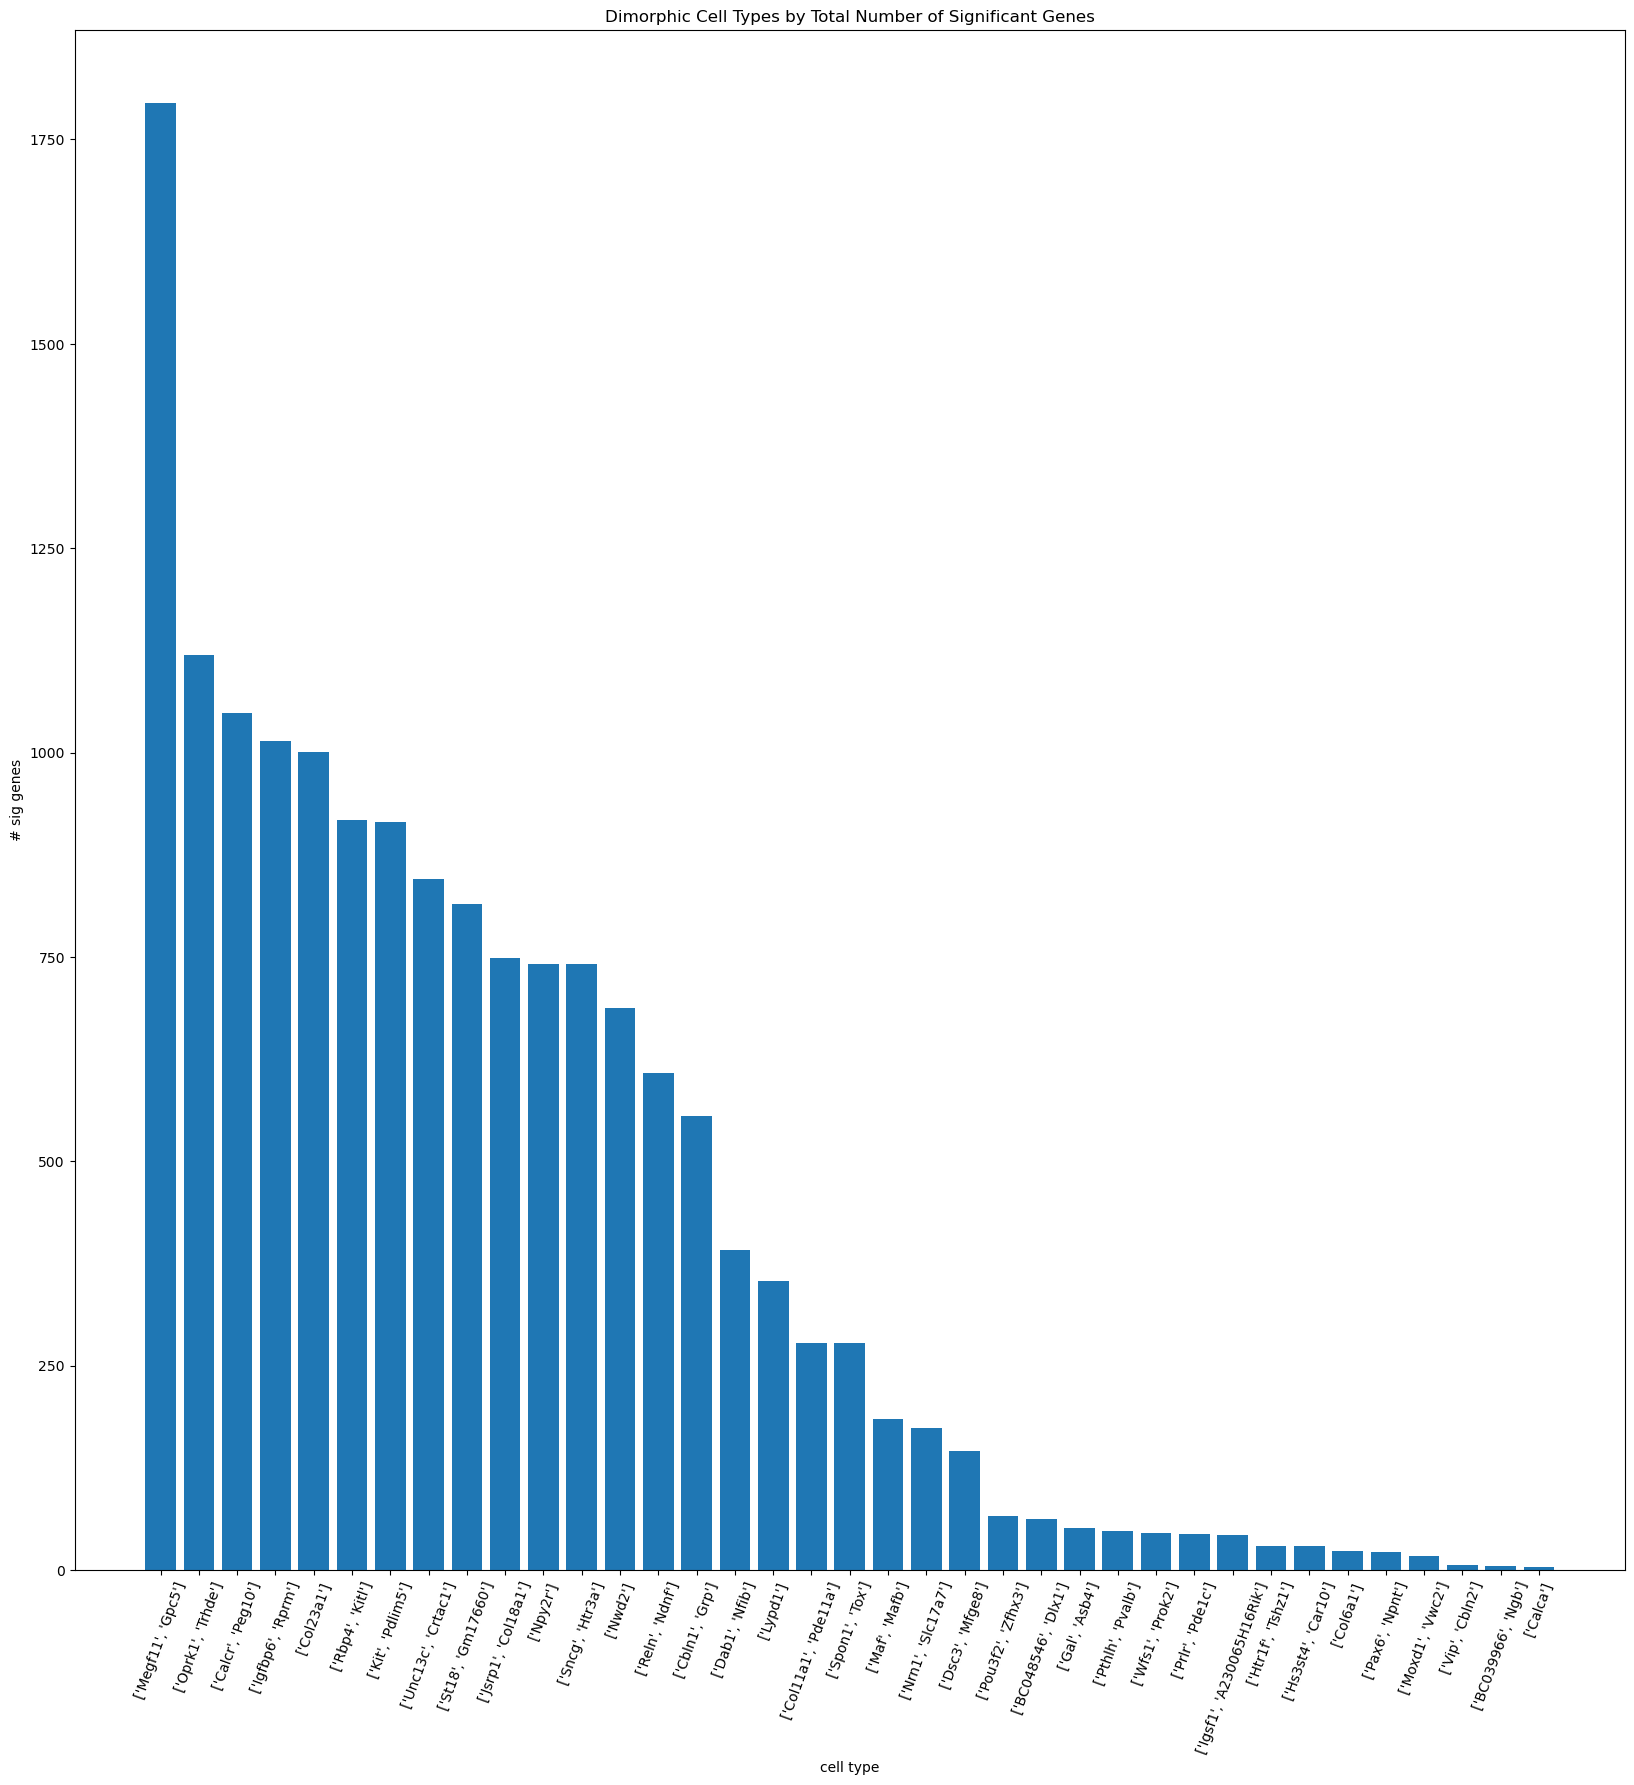

In [1026]:
subset = 20
fig,ax = plt.subplots(figsize = (20,20))
#plt.plot(cts_per_gene_df_uni_ct_sorted['unique_cts_counts'][:subset], '.')
#ax.set_xticklabels(cts_per_gene_df_uni_ct_sorted.index[:subset])
plt.bar(x = dimorph_cell_types_df_sorted.index,height=dimorph_cell_types_df_sorted['gene_count'])
ax.set_xticks(dimorph_cell_types_df_sorted.index)
ax.set_xticklabels(dimorph_cell_types_df_sorted['ct'])

for tick in ax.get_xticklabels():
    tick.set_rotation(70)
ax.set_ylabel('# sig genes')
ax.set_xlabel('cell type')
ax.set_title('Dimorphic Cell Types by Total Number of Significant Genes')

plt.savefig(output_folder+'gene_counts_per_ct'+'.png')
plt.show()

## Plot against group size

In [1037]:
gaba_metadata.loc[:,gaba_metadata.loc['cluster_label',:]==49].shape[1]

194

In [1038]:
grp_size = []
for id in dimorph_cell_types_df_sorted['id']:
    gs = gaba_metadata.loc[:,gaba_metadata.loc['cluster_label',:]==id].shape[1]
    grp_size.append(gs)

In [1040]:
dimorph_cell_types_df_sorted.insert(4, 'grp_size', grp_size)
dimorph_cell_types_df_sorted

,index,id,ct,gene_count,grp_size
0,35,49,"[Megf11, Gpc5]",1794,194
1,18,27,"[Oprk1, Trhde]",1119,501
2,11,17,"[Calcr, Peg10]",1048,345
3,15,22,"[Igfbp6, Rprm]",1014,361
4,26,37,[Col23a1],1001,280
5,6,10,"[Rbp4, Kitl]",918,337
6,4,7,"[Kit, Pdlim5]",915,509
7,14,21,"[Unc13c, Crtac1]",846,458
8,10,16,"[St18, Gm17660]",815,583
9,17,24,"[Jsrp1, Col18a1]",749,391


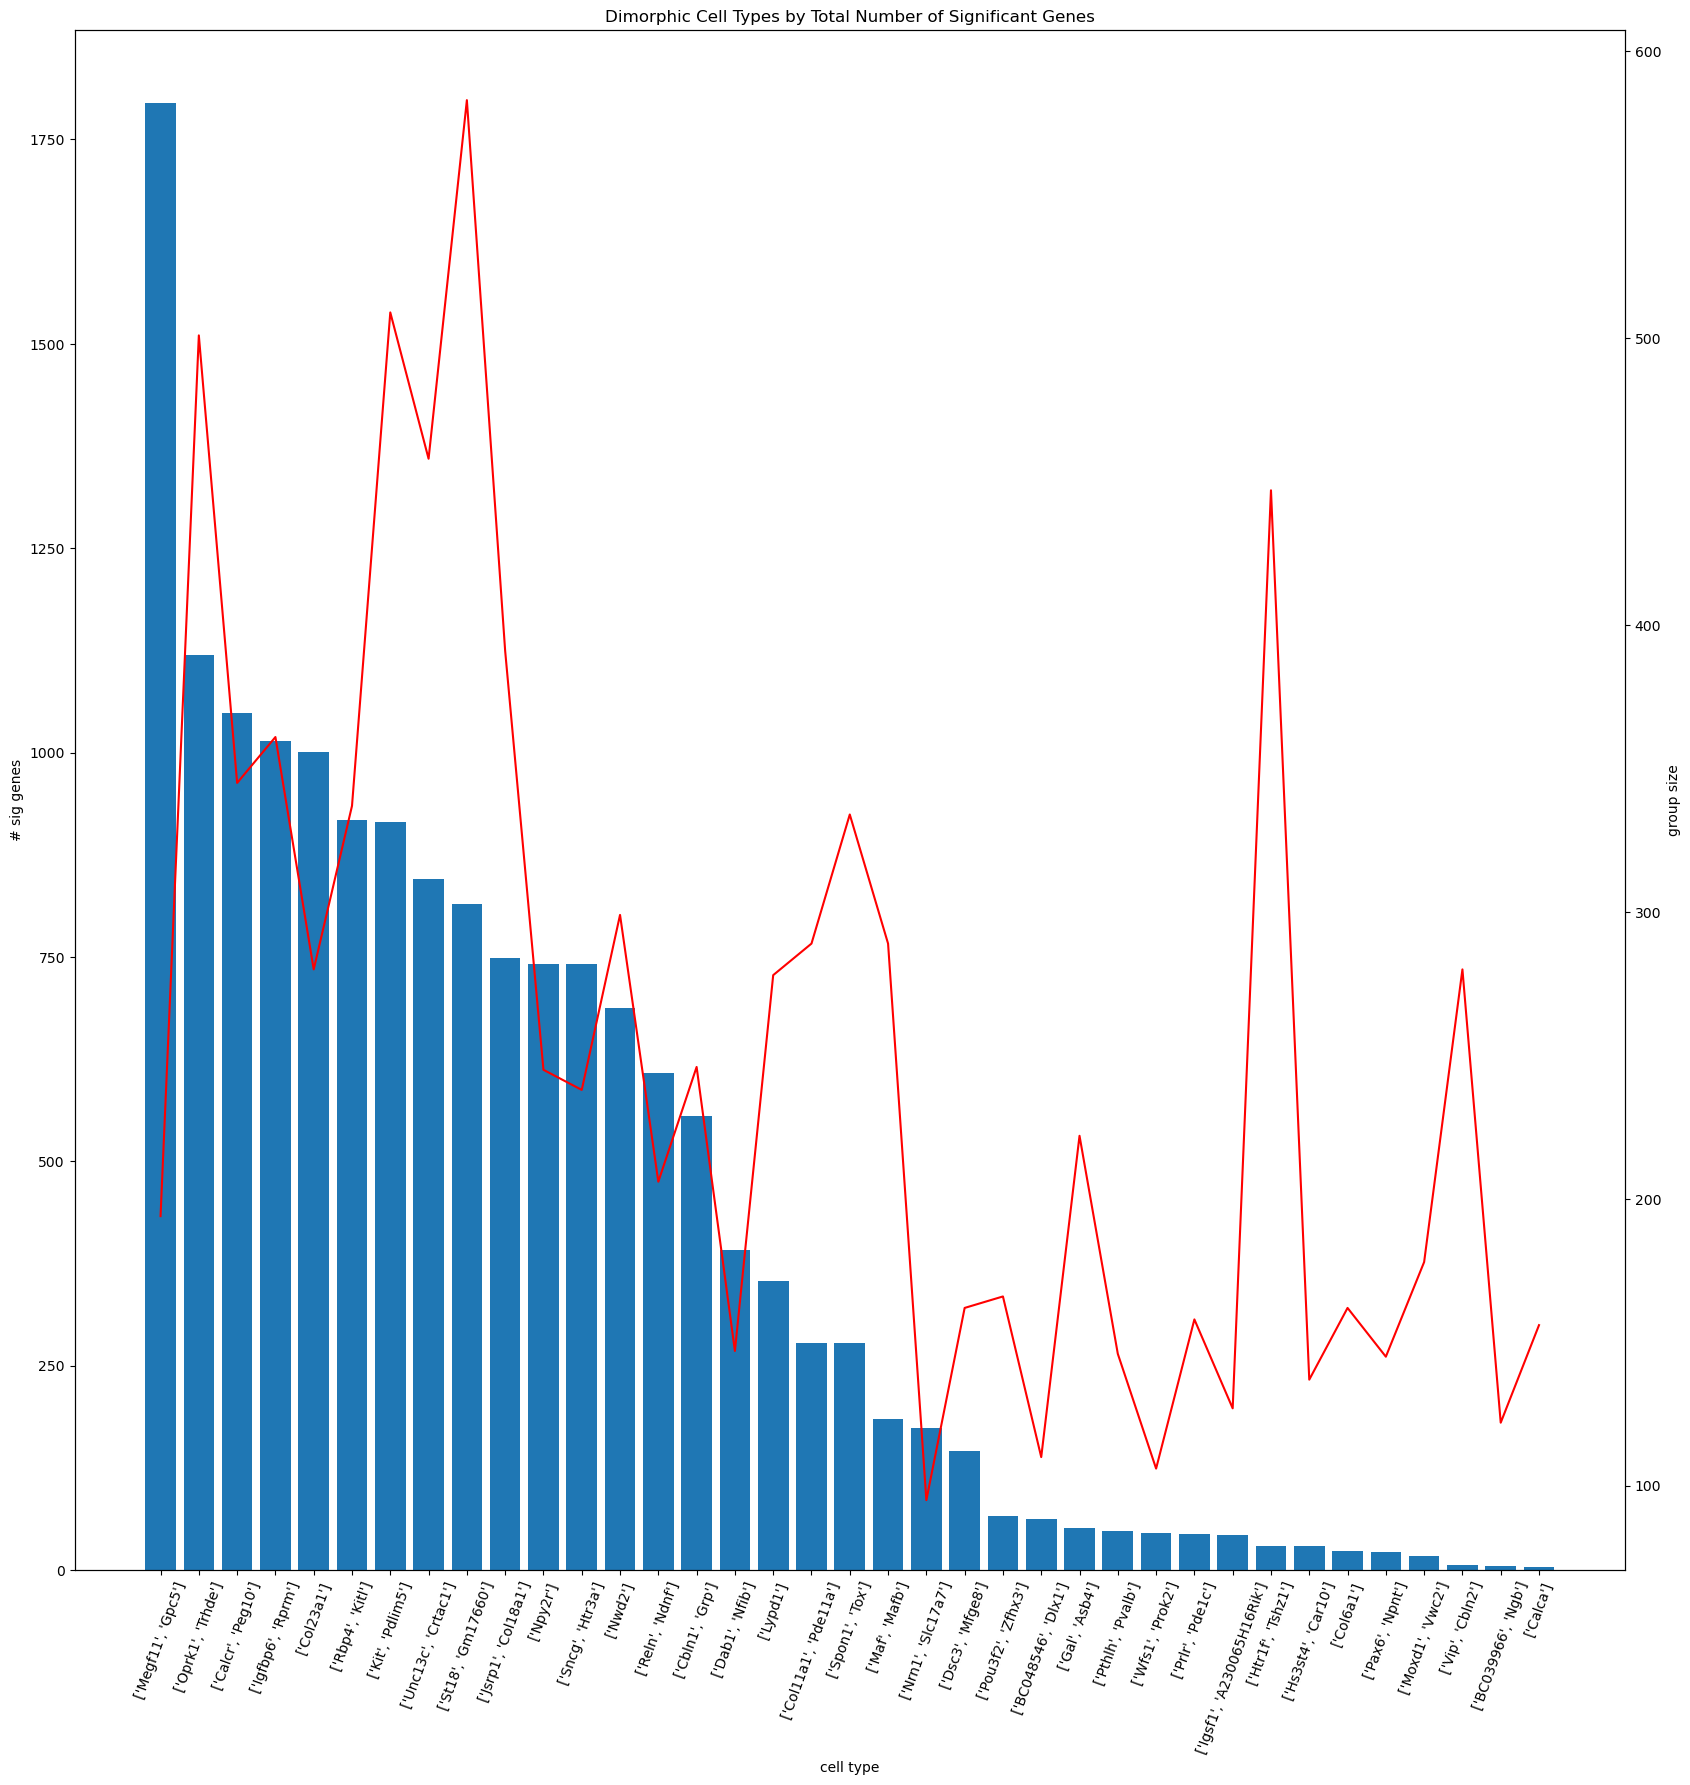

In [1063]:
subset = 20
fig,ax = plt.subplots(figsize = (20,20))
#plt.plot(cts_per_gene_df_uni_ct_sorted['unique_cts_counts'][:subset], '.')
#ax.set_xticklabels(cts_per_gene_df_uni_ct_sorted.index[:subset])
ax.bar(x = dimorph_cell_types_df_sorted.index,height=dimorph_cell_types_df_sorted['gene_count'])
ax.set_xticks(dimorph_cell_types_df_sorted.index)
ax.set_xticklabels(dimorph_cell_types_df_sorted['ct'])

for tick in ax.get_xticklabels():
    tick.set_rotation(70)
ax.set_ylabel('# sig genes')
ax.set_xlabel('cell type')
ax.set_title('Dimorphic Cell Types by Total Number of Significant Genes')

ax2 = ax.twinx()
ax2.plot(dimorph_cell_types_df_sorted.index,dimorph_cell_types_df_sorted['grp_size'],color = 'r')
ax2.set_ylabel('group size')

plt.savefig(output_folder+'gene_counts_per_ct_w_grp_size'+'.png')
plt.show()